In [2]:
%matplotlib inline
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
from skimage.filters import *
from skimage.transform import *
import os
import math
from math import floor

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
def PS(T, r):
    T = np.transpose(T, (1, 2, 0))
    rW = r*len(T)
    rH = r*len(T[0])
    C = len(T[0][0])/(r*r)

    # make sure C is an integer and cast if this is the case
    assert(C == int(C))
    C = int(C)
    
    res = np.zeros((rW, rH, C))

    for x in range(len(res)):
        for y in range(len(res[x])):
            for c in range(len(res[x][y])):
                res[x][y][c] = \
                    T[x // r][y // r][C*r*(y % r) + C*(x % r) + c]
    return res

def PS_inv(img, r):
    r2 = r*r
    W = len(img)/r
    H = len(img[0])/r
    C = len(img[0][0])
    Cr2 = C*r2

    # Make sure H and W are integers
    assert(int(H) == H and int(W) == W)
    H, W = int(H), int(W)

    res = np.zeros((W, H, Cr2))

    for x in range(len(img)):
        for y in range(len(img[x])):
            for c in range(len(img[x][y])):
                res[x // r][y // r][C*r*(y % r) + C*(x % r) + c] = img[x][y][c]
    return res


In [5]:
# hyperparameters
r = 2 # upscaling ratio
blur = 1 # gaussian blur (missing ???)
C = 3 # colour channels
lr_start = 0.01 # learning rate
lr_end = 0.0001
u = 0.0001 # threshold for lowering the lr (missing ???)

(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


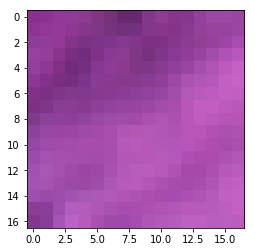

DONE!!!


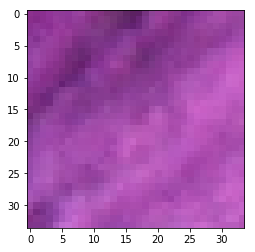

In [6]:
"""
Downsample images
- gaussian blur
- resize by downsample factor (using interpolation)

How To Use:
    function lr_dataset_from_path takes a path to the dataset of HR image png files and returns an ndarray to use for training the model
    
For debugging/showing examples:
    (see bottom of file)
    save_png set to True to save resulting lr images in specified directory.
    !check the param_ varaiables
"""

SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17


# hr_dataset_path: dir to the hr_dataset png files
# downscale: downscale factor, e.g. if original image 64*64 and downscale=2 then result will be 32*32
# returns list of numpy.ndarray representing the lr_images
def lr_dataset_from_path(hr_dataset_path, downscale):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))
    return lr_images(original_images, downscale)  # ndarray of images


def torchDataloader_from_path(hr_dataset_path, downscale, gaussian_sigma):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))

    # subsample
    subsamples_hr = []
    subsamples_hr_rev_shuff = []
    for i in range(len(original_images)):
        temp_subsamples = subsample(original_images[i], downscale)
        subsamples_hr += temp_subsamples
        for sample_indx in range(len(temp_subsamples)):
            subsamples_hr_rev_shuff.append(PS_inv(temp_subsamples[sample_indx], downscale))  # labels
    lr_dataset = lr_images(subsamples_hr, downscale, gaussian_sigma)  # ndarray of images

    return toDataloader(lr_dataset, subsamples_hr_rev_shuff)


# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real, downscale, gaussianSigma):
    lr_images = []
    for img in range(len(images_real)):
        img_blurred = gaussian(images_real[img], sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        lr_images.append(resize(img_blurred, (img_blurred.shape[0] // downscale, img_blurred.shape[1] // downscale)))
    return lr_images


# extract a 17r*17r subsample from original image, no overlap so every pixel appears at most once in output
def subsample(image_real, downscale):
    subsample_size = SUBSAMPLING_SAMPLE_SIZE * downscale
    subsample_stride = SUBSAMPLING_STRIDE_SIZE * downscale
    subsamples = []
    for y in range(math.floor((image_real.shape[0] - (subsample_size - subsample_stride)) / subsample_stride)):
        for x in range(math.floor((image_real.shape[1] - (subsample_size - subsample_stride)) / subsample_stride)):
            ss = image_real[(y * subsample_stride):(y * subsample_stride) + subsample_size,
                 (x * subsample_stride):(x * subsample_stride) + subsample_size]
            subsamples.append(ss)

    return subsamples


# returns a torch Dataloader (to iterate over training data) using the training data samples and traing data labels
def toDataloader(train_data, train_labels):
    labeled_data = []
    for i in range(len(train_data)):
        print(train_data[i].shape)
        print(train_labels[i].shape)
        labeled_data.append([np.transpose(train_data[i], (2, 0, 1)), np.transpose(train_labels[i], (2, 0, 1))])
    trainDataloader = DataLoader(labeled_data)
    return trainDataloader


# ---DEBUG--- uncomment to show first image
# pyplot.imshow(original_images[0])
# pyplot.imshow(lr_dataset[0])

# ----TEST DATALOADER ----
dataloader = torchDataloader_from_path('datasets/T91', r, blur)

print("TESTIng datalaoder iter")
i1, l1 = next(iter(dataloader))
imshow(i1[0])
plt.imshow(PS(l1[0], r))

print("DONE!!!")

In [7]:
use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(C, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, r*r*C, 3, padding=1)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = self.conv3(x)
        return x


net = Net()
net.double()

if use_gpu:
    net = net.cuda()

In [8]:
# define loss fuction
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9) # momentum???
# scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=u, min_lr=lr_end)

In [9]:
losses = []

for epoch in range(200):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels)
        loss.backward()
#         sceduler.step()
        optimizer.step()

        # print statistics
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    print(epoch+1, epoch_loss / len(inputs))    
    losses.append(epoch_loss / len(inputs))
        

print('Finished Training')

[1,    10] loss: 0.21064
[1,    20] loss: 0.05691
[1,    30] loss: 0.04477
[1,    40] loss: 0.04898
[1,    50] loss: 0.05218
[1,    60] loss: 0.03750
[1,    70] loss: 0.03297
[1,    80] loss: 0.02884
[1,    90] loss: 0.02060
[1,   100] loss: 0.01135
[1,   110] loss: 0.04068
[1,   120] loss: 0.02776
[1,   130] loss: 0.02030
[1,   140] loss: 0.01392
[1,   150] loss: 0.03632
[1,   160] loss: 0.01125
[1,   170] loss: 0.01136
[1,   180] loss: 0.00854
[1,   190] loss: 0.02124
[1,   200] loss: 0.01730
[1,   210] loss: 0.02443
[1,   220] loss: 0.02658
[1,   230] loss: 0.01356
[1,   240] loss: 0.01015
[1,   250] loss: 0.01535
[1,   260] loss: 0.01198
[1,   270] loss: 0.01118
[1,   280] loss: 0.01128
[1,   290] loss: 0.01470
[1,   300] loss: 0.01033
[1,   310] loss: 0.01026
[1,   320] loss: 0.01014
[1,   330] loss: 0.01001
[1,   340] loss: 0.01098
[1,   350] loss: 0.01006
[1,   360] loss: 0.01631
[1,   370] loss: 0.02342
[1,   380] loss: 0.01474
[1,   390] loss: 0.01144
[1,   400] loss: 0.00737


[2,  1400] loss: 0.00915
[2,  1410] loss: 0.00691
[2,  1420] loss: 0.00750
[2,  1430] loss: 0.00351
[2,  1440] loss: 0.00529
[2,  1450] loss: 0.00359
[2,  1460] loss: 0.00356
[2,  1470] loss: 0.00389
[2,  1480] loss: 0.00314
[2,  1490] loss: 0.00285
[2,  1500] loss: 0.00234
[2,  1510] loss: 0.00254
[2,  1520] loss: 0.00304
[2,  1530] loss: 0.00161
[2,  1540] loss: 0.00320
[2,  1550] loss: 0.00191
[2,  1560] loss: 0.00205
[2,  1570] loss: 0.00254
[2,  1580] loss: 0.00269
[2,  1590] loss: 0.00280
[2,  1600] loss: 0.00209
[2,  1610] loss: 0.00481
[2,  1620] loss: 0.00398
[2,  1630] loss: 0.00461
[2,  1640] loss: 0.00318
[2,  1650] loss: 0.00132
[2,  1660] loss: 0.00130
[2,  1670] loss: 0.00153
[2,  1680] loss: 0.00145
[2,  1690] loss: 0.00177
[2,  1700] loss: 0.00137
[2,  1710] loss: 0.00146
[2,  1720] loss: 0.00154
[2,  1730] loss: 0.00186
[2,  1740] loss: 0.00177
[2,  1750] loss: 0.00243
[2,  1760] loss: 0.00210
[2,  1770] loss: 0.00599
[2,  1780] loss: 0.00880
[2,  1790] loss: 0.00897


[4,   920] loss: 0.00386
[4,   930] loss: 0.00320
[4,   940] loss: 0.00246
[4,   950] loss: 0.00282
[4,   960] loss: 0.00110
[4,   970] loss: 0.00094
[4,   980] loss: 0.00096
[4,   990] loss: 0.00088
[4,  1000] loss: 0.00107
[4,  1010] loss: 0.00111
[4,  1020] loss: 0.00133
[4,  1030] loss: 0.00170
[4,  1040] loss: 0.00199
[4,  1050] loss: 0.00154
[4,  1060] loss: 0.00199
[4,  1070] loss: 0.00135
[4,  1080] loss: 0.00105
[4,  1090] loss: 0.00083
[4,  1100] loss: 0.00132
[4,  1110] loss: 0.00228
[4,  1120] loss: 0.00307
[4,  1130] loss: 0.00341
[4,  1140] loss: 0.00371
[4,  1150] loss: 0.00297
[4,  1160] loss: 0.00310
[4,  1170] loss: 0.00352
[4,  1180] loss: 0.00307
[4,  1190] loss: 0.00288
[4,  1200] loss: 0.00305
[4,  1210] loss: 0.00322
[4,  1220] loss: 0.00168
[4,  1230] loss: 0.00105
[4,  1240] loss: 0.00085
[4,  1250] loss: 0.00106
[4,  1260] loss: 0.00086
[4,  1270] loss: 0.00083
[4,  1280] loss: 0.00088
[4,  1290] loss: 0.00162
[4,  1300] loss: 0.00185
[4,  1310] loss: 0.00110


[6,   440] loss: 0.00117
[6,   450] loss: 0.00091
[6,   460] loss: 0.00143
[6,   470] loss: 0.00250
[6,   480] loss: 0.00535
[6,   490] loss: 0.00616
[6,   500] loss: 0.00459
[6,   510] loss: 0.00394
[6,   520] loss: 0.00419
[6,   530] loss: 0.00185
[6,   540] loss: 0.00115
[6,   550] loss: 0.00490
[6,   560] loss: 0.00529
[6,   570] loss: 0.00518
[6,   580] loss: 0.00326
[6,   590] loss: 0.00058
[6,   600] loss: 0.00080
[6,   610] loss: 0.00101
[6,   620] loss: 0.00207
[6,   630] loss: 0.00215
[6,   640] loss: 0.00163
[6,   650] loss: 0.00187
[6,   660] loss: 0.00220
[6,   670] loss: 0.00271
[6,   680] loss: 0.00269
[6,   690] loss: 0.00114
[6,   700] loss: 0.00133
[6,   710] loss: 0.00176
[6,   720] loss: 0.00230
[6,   730] loss: 0.00063
[6,   740] loss: 0.00066
[6,   750] loss: 0.00123
[6,   760] loss: 0.00161
[6,   770] loss: 0.00176
[6,   780] loss: 0.00175
[6,   790] loss: 0.00159
[6,   800] loss: 0.00479
[6,   810] loss: 0.00488
[6,   820] loss: 0.00503
[6,   830] loss: 0.00363


[7,  1830] loss: 0.00388
[7,  1840] loss: 0.00608
[7,  1850] loss: 0.00702
[7,  1860] loss: 0.00678
[7,  1870] loss: 0.00138
7 3.5971909383790908
[8,    10] loss: 0.00101
[8,    20] loss: 0.00177
[8,    30] loss: 0.00116
[8,    40] loss: 0.00428
[8,    50] loss: 0.00841
[8,    60] loss: 0.00485
[8,    70] loss: 0.00408
[8,    80] loss: 0.00381
[8,    90] loss: 0.00378
[8,   100] loss: 0.00196
[8,   110] loss: 0.00088
[8,   120] loss: 0.00096
[8,   130] loss: 0.00088
[8,   140] loss: 0.00079
[8,   150] loss: 0.00027
[8,   160] loss: 0.00019
[8,   170] loss: 0.00038
[8,   180] loss: 0.00084
[8,   190] loss: 0.00118
[8,   200] loss: 0.00136
[8,   210] loss: 0.00145
[8,   220] loss: 0.00122
[8,   230] loss: 0.00093
[8,   240] loss: 0.00093
[8,   250] loss: 0.00243
[8,   260] loss: 0.00155
[8,   270] loss: 0.00264
[8,   280] loss: 0.00300
[8,   290] loss: 0.00149
[8,   300] loss: 0.00144
[8,   310] loss: 0.00186
[8,   320] loss: 0.00100
[8,   330] loss: 0.00140
[8,   340] loss: 0.00185
[8, 

[9,  1350] loss: 0.00091
[9,  1360] loss: 0.00106
[9,  1370] loss: 0.00067
[9,  1380] loss: 0.00102
[9,  1390] loss: 0.00427
[9,  1400] loss: 0.00515
[9,  1410] loss: 0.00355
[9,  1420] loss: 0.00404
[9,  1430] loss: 0.00080
[9,  1440] loss: 0.00257
[9,  1450] loss: 0.00119
[9,  1460] loss: 0.00158
[9,  1470] loss: 0.00163
[9,  1480] loss: 0.00133
[9,  1490] loss: 0.00131
[9,  1500] loss: 0.00084
[9,  1510] loss: 0.00107
[9,  1520] loss: 0.00121
[9,  1530] loss: 0.00055
[9,  1540] loss: 0.00144
[9,  1550] loss: 0.00073
[9,  1560] loss: 0.00071
[9,  1570] loss: 0.00093
[9,  1580] loss: 0.00115
[9,  1590] loss: 0.00125
[9,  1600] loss: 0.00081
[9,  1610] loss: 0.00181
[9,  1620] loss: 0.00146
[9,  1630] loss: 0.00208
[9,  1640] loss: 0.00131
[9,  1650] loss: 0.00050
[9,  1660] loss: 0.00034
[9,  1670] loss: 0.00047
[9,  1680] loss: 0.00043
[9,  1690] loss: 0.00072
[9,  1700] loss: 0.00058
[9,  1710] loss: 0.00060
[9,  1720] loss: 0.00060
[9,  1730] loss: 0.00078
[9,  1740] loss: 0.00056


[11,   760] loss: 0.00120
[11,   770] loss: 0.00133
[11,   780] loss: 0.00134
[11,   790] loss: 0.00123
[11,   800] loss: 0.00352
[11,   810] loss: 0.00361
[11,   820] loss: 0.00363
[11,   830] loss: 0.00264
[11,   840] loss: 0.00165
[11,   850] loss: 0.00232
[11,   860] loss: 0.00209
[11,   870] loss: 0.00249
[11,   880] loss: 0.00283
[11,   890] loss: 0.00232
[11,   900] loss: 0.00295
[11,   910] loss: 0.00291
[11,   920] loss: 0.00287
[11,   930] loss: 0.00237
[11,   940] loss: 0.00176
[11,   950] loss: 0.00198
[11,   960] loss: 0.00056
[11,   970] loss: 0.00034
[11,   980] loss: 0.00037
[11,   990] loss: 0.00034
[11,  1000] loss: 0.00047
[11,  1010] loss: 0.00053
[11,  1020] loss: 0.00074
[11,  1030] loss: 0.00108
[11,  1040] loss: 0.00132
[11,  1050] loss: 0.00096
[11,  1060] loss: 0.00129
[11,  1070] loss: 0.00083
[11,  1080] loss: 0.00063
[11,  1090] loss: 0.00050
[11,  1100] loss: 0.00082
[11,  1110] loss: 0.00148
[11,  1120] loss: 0.00200
[11,  1130] loss: 0.00227
[11,  1140] 

[13,   150] loss: 0.00019
[13,   160] loss: 0.00012
[13,   170] loss: 0.00027
[13,   180] loss: 0.00069
[13,   190] loss: 0.00093
[13,   200] loss: 0.00104
[13,   210] loss: 0.00111
[13,   220] loss: 0.00081
[13,   230] loss: 0.00061
[13,   240] loss: 0.00072
[13,   250] loss: 0.00214
[13,   260] loss: 0.00134
[13,   270] loss: 0.00227
[13,   280] loss: 0.00261
[13,   290] loss: 0.00122
[13,   300] loss: 0.00113
[13,   310] loss: 0.00155
[13,   320] loss: 0.00076
[13,   330] loss: 0.00106
[13,   340] loss: 0.00153
[13,   350] loss: 0.00160
[13,   360] loss: 0.00084
[13,   370] loss: 0.00052
[13,   380] loss: 0.00061
[13,   390] loss: 0.00031
[13,   400] loss: 0.00042
[13,   410] loss: 0.00048
[13,   420] loss: 0.00034
[13,   430] loss: 0.00034
[13,   440] loss: 0.00073
[13,   450] loss: 0.00051
[13,   460] loss: 0.00095
[13,   470] loss: 0.00182
[13,   480] loss: 0.00406
[13,   490] loss: 0.00465
[13,   500] loss: 0.00345
[13,   510] loss: 0.00305
[13,   520] loss: 0.00320
[13,   530] 

[14,  1420] loss: 0.00366
[14,  1430] loss: 0.00069
[14,  1440] loss: 0.00228
[14,  1450] loss: 0.00102
[14,  1460] loss: 0.00142
[14,  1470] loss: 0.00139
[14,  1480] loss: 0.00117
[14,  1490] loss: 0.00113
[14,  1500] loss: 0.00071
[14,  1510] loss: 0.00092
[14,  1520] loss: 0.00102
[14,  1530] loss: 0.00046
[14,  1540] loss: 0.00123
[14,  1550] loss: 0.00061
[14,  1560] loss: 0.00058
[14,  1570] loss: 0.00075
[14,  1580] loss: 0.00097
[14,  1590] loss: 0.00105
[14,  1600] loss: 0.00066
[14,  1610] loss: 0.00151
[14,  1620] loss: 0.00122
[14,  1630] loss: 0.00177
[14,  1640] loss: 0.00112
[14,  1650] loss: 0.00043
[14,  1660] loss: 0.00027
[14,  1670] loss: 0.00037
[14,  1680] loss: 0.00034
[14,  1690] loss: 0.00061
[14,  1700] loss: 0.00048
[14,  1710] loss: 0.00050
[14,  1720] loss: 0.00049
[14,  1730] loss: 0.00065
[14,  1740] loss: 0.00048
[14,  1750] loss: 0.00062
[14,  1760] loss: 0.00059
[14,  1770] loss: 0.00181
[14,  1780] loss: 0.00227
[14,  1790] loss: 0.00256
[14,  1800] 

[16,   810] loss: 0.00311
[16,   820] loss: 0.00308
[16,   830] loss: 0.00230
[16,   840] loss: 0.00147
[16,   850] loss: 0.00210
[16,   860] loss: 0.00189
[16,   870] loss: 0.00226
[16,   880] loss: 0.00251
[16,   890] loss: 0.00213
[16,   900] loss: 0.00276
[16,   910] loss: 0.00270
[16,   920] loss: 0.00270
[16,   930] loss: 0.00224
[16,   940] loss: 0.00164
[16,   950] loss: 0.00183
[16,   960] loss: 0.00049
[16,   970] loss: 0.00027
[16,   980] loss: 0.00029
[16,   990] loss: 0.00027
[16,  1000] loss: 0.00039
[16,  1010] loss: 0.00046
[16,  1020] loss: 0.00064
[16,  1030] loss: 0.00097
[16,  1040] loss: 0.00121
[16,  1050] loss: 0.00086
[16,  1060] loss: 0.00115
[16,  1070] loss: 0.00073
[16,  1080] loss: 0.00057
[16,  1090] loss: 0.00045
[16,  1100] loss: 0.00073
[16,  1110] loss: 0.00133
[16,  1120] loss: 0.00179
[16,  1130] loss: 0.00205
[16,  1140] loss: 0.00224
[16,  1150] loss: 0.00162
[16,  1160] loss: 0.00188
[16,  1170] loss: 0.00216
[16,  1180] loss: 0.00179
[16,  1190] 

[18,   200] loss: 0.00093
[18,   210] loss: 0.00099
[18,   220] loss: 0.00066
[18,   230] loss: 0.00050
[18,   240] loss: 0.00064
[18,   250] loss: 0.00202
[18,   260] loss: 0.00126
[18,   270] loss: 0.00213
[18,   280] loss: 0.00245
[18,   290] loss: 0.00111
[18,   300] loss: 0.00100
[18,   310] loss: 0.00141
[18,   320] loss: 0.00065
[18,   330] loss: 0.00090
[18,   340] loss: 0.00139
[18,   350] loss: 0.00147
[18,   360] loss: 0.00073
[18,   370] loss: 0.00046
[18,   380] loss: 0.00052
[18,   390] loss: 0.00025
[18,   400] loss: 0.00037
[18,   410] loss: 0.00042
[18,   420] loss: 0.00028
[18,   430] loss: 0.00028
[18,   440] loss: 0.00065
[18,   450] loss: 0.00044
[18,   460] loss: 0.00086
[18,   470] loss: 0.00167
[18,   480] loss: 0.00377
[18,   490] loss: 0.00430
[18,   500] loss: 0.00318
[18,   510] loss: 0.00284
[18,   520] loss: 0.00296
[18,   530] loss: 0.00128
[18,   540] loss: 0.00075
[18,   550] loss: 0.00362
[18,   560] loss: 0.00378
[18,   570] loss: 0.00380
[18,   580] 

[19,  1470] loss: 0.00127
[19,  1480] loss: 0.00108
[19,  1490] loss: 0.00104
[19,  1500] loss: 0.00065
[19,  1510] loss: 0.00085
[19,  1520] loss: 0.00094
[19,  1530] loss: 0.00041
[19,  1540] loss: 0.00113
[19,  1550] loss: 0.00056
[19,  1560] loss: 0.00052
[19,  1570] loss: 0.00067
[19,  1580] loss: 0.00089
[19,  1590] loss: 0.00096
[19,  1600] loss: 0.00059
[19,  1610] loss: 0.00139
[19,  1620] loss: 0.00112
[19,  1630] loss: 0.00163
[19,  1640] loss: 0.00104
[19,  1650] loss: 0.00039
[19,  1660] loss: 0.00024
[19,  1670] loss: 0.00032
[19,  1680] loss: 0.00030
[19,  1690] loss: 0.00056
[19,  1700] loss: 0.00044
[19,  1710] loss: 0.00045
[19,  1720] loss: 0.00044
[19,  1730] loss: 0.00058
[19,  1740] loss: 0.00044
[19,  1750] loss: 0.00058
[19,  1760] loss: 0.00055
[19,  1770] loss: 0.00164
[19,  1780] loss: 0.00203
[19,  1790] loss: 0.00228
[19,  1800] loss: 0.00106
[19,  1810] loss: 0.00094
[19,  1820] loss: 0.00057
[19,  1830] loss: 0.00294
[19,  1840] loss: 0.00482
[19,  1850] 

[21,   860] loss: 0.00179
[21,   870] loss: 0.00214
[21,   880] loss: 0.00236
[21,   890] loss: 0.00203
[21,   900] loss: 0.00265
[21,   910] loss: 0.00259
[21,   920] loss: 0.00260
[21,   930] loss: 0.00215
[21,   940] loss: 0.00157
[21,   950] loss: 0.00174
[21,   960] loss: 0.00046
[21,   970] loss: 0.00024
[21,   980] loss: 0.00026
[21,   990] loss: 0.00025
[21,  1000] loss: 0.00036
[21,  1010] loss: 0.00042
[21,  1020] loss: 0.00059
[21,  1030] loss: 0.00092
[21,  1040] loss: 0.00115
[21,  1050] loss: 0.00081
[21,  1060] loss: 0.00109
[21,  1070] loss: 0.00068
[21,  1080] loss: 0.00053
[21,  1090] loss: 0.00042
[21,  1100] loss: 0.00067
[21,  1110] loss: 0.00125
[21,  1120] loss: 0.00166
[21,  1130] loss: 0.00192
[21,  1140] loss: 0.00211
[21,  1150] loss: 0.00151
[21,  1160] loss: 0.00178
[21,  1170] loss: 0.00204
[21,  1180] loss: 0.00169
[21,  1190] loss: 0.00158
[21,  1200] loss: 0.00180
[21,  1210] loss: 0.00186
[21,  1220] loss: 0.00089
[21,  1230] loss: 0.00047
[21,  1240] 

[23,   250] loss: 0.00194
[23,   260] loss: 0.00121
[23,   270] loss: 0.00205
[23,   280] loss: 0.00237
[23,   290] loss: 0.00105
[23,   300] loss: 0.00093
[23,   310] loss: 0.00133
[23,   320] loss: 0.00059
[23,   330] loss: 0.00082
[23,   340] loss: 0.00131
[23,   350] loss: 0.00139
[23,   360] loss: 0.00066
[23,   370] loss: 0.00043
[23,   380] loss: 0.00048
[23,   390] loss: 0.00023
[23,   400] loss: 0.00033
[23,   410] loss: 0.00038
[23,   420] loss: 0.00025
[23,   430] loss: 0.00025
[23,   440] loss: 0.00060
[23,   450] loss: 0.00041
[23,   460] loss: 0.00081
[23,   470] loss: 0.00159
[23,   480] loss: 0.00360
[23,   490] loss: 0.00410
[23,   500] loss: 0.00302
[23,   510] loss: 0.00271
[23,   520] loss: 0.00283
[23,   530] loss: 0.00121
[23,   540] loss: 0.00071
[23,   550] loss: 0.00347
[23,   560] loss: 0.00361
[23,   570] loss: 0.00364
[23,   580] loss: 0.00209
[23,   590] loss: 0.00028
[23,   600] loss: 0.00041
[23,   610] loss: 0.00058
[23,   620] loss: 0.00126
[23,   630] 

[24,  1520] loss: 0.00089
[24,  1530] loss: 0.00039
[24,  1540] loss: 0.00107
[24,  1550] loss: 0.00053
[24,  1560] loss: 0.00049
[24,  1570] loss: 0.00062
[24,  1580] loss: 0.00083
[24,  1590] loss: 0.00090
[24,  1600] loss: 0.00055
[24,  1610] loss: 0.00132
[24,  1620] loss: 0.00105
[24,  1630] loss: 0.00154
[24,  1640] loss: 0.00098
[24,  1650] loss: 0.00037
[24,  1660] loss: 0.00022
[24,  1670] loss: 0.00030
[24,  1680] loss: 0.00027
[24,  1690] loss: 0.00052
[24,  1700] loss: 0.00041
[24,  1710] loss: 0.00042
[24,  1720] loss: 0.00041
[24,  1730] loss: 0.00054
[24,  1740] loss: 0.00042
[24,  1750] loss: 0.00055
[24,  1760] loss: 0.00052
[24,  1770] loss: 0.00153
[24,  1780] loss: 0.00188
[24,  1790] loss: 0.00209
[24,  1800] loss: 0.00098
[24,  1810] loss: 0.00088
[24,  1820] loss: 0.00053
[24,  1830] loss: 0.00280
[24,  1840] loss: 0.00464
[24,  1850] loss: 0.00544
[24,  1860] loss: 0.00529
[24,  1870] loss: 0.00103
24 2.4534381819368694
[25,    10] loss: 0.00057
[25,    20] loss

[26,   910] loss: 0.00251
[26,   920] loss: 0.00252
[26,   930] loss: 0.00209
[26,   940] loss: 0.00152
[26,   950] loss: 0.00168
[26,   960] loss: 0.00044
[26,   970] loss: 0.00022
[26,   980] loss: 0.00024
[26,   990] loss: 0.00023
[26,  1000] loss: 0.00034
[26,  1010] loss: 0.00039
[26,  1020] loss: 0.00056
[26,  1030] loss: 0.00088
[26,  1040] loss: 0.00111
[26,  1050] loss: 0.00078
[26,  1060] loss: 0.00104
[26,  1070] loss: 0.00065
[26,  1080] loss: 0.00051
[26,  1090] loss: 0.00041
[26,  1100] loss: 0.00063
[26,  1110] loss: 0.00119
[26,  1120] loss: 0.00157
[26,  1130] loss: 0.00183
[26,  1140] loss: 0.00202
[26,  1150] loss: 0.00144
[26,  1160] loss: 0.00172
[26,  1170] loss: 0.00197
[26,  1180] loss: 0.00162
[26,  1190] loss: 0.00152
[26,  1200] loss: 0.00173
[26,  1210] loss: 0.00179
[26,  1220] loss: 0.00085
[26,  1230] loss: 0.00044
[26,  1240] loss: 0.00033
[26,  1250] loss: 0.00047
[26,  1260] loss: 0.00036
[26,  1270] loss: 0.00037
[26,  1280] loss: 0.00039
[26,  1290] 

[28,   300] loss: 0.00087
[28,   310] loss: 0.00128
[28,   320] loss: 0.00055
[28,   330] loss: 0.00076
[28,   340] loss: 0.00126
[28,   350] loss: 0.00134
[28,   360] loss: 0.00061
[28,   370] loss: 0.00040
[28,   380] loss: 0.00045
[28,   390] loss: 0.00021
[28,   400] loss: 0.00031
[28,   410] loss: 0.00035
[28,   420] loss: 0.00023
[28,   430] loss: 0.00023
[28,   440] loss: 0.00057
[28,   450] loss: 0.00038
[28,   460] loss: 0.00078
[28,   470] loss: 0.00154
[28,   480] loss: 0.00348
[28,   490] loss: 0.00395
[28,   500] loss: 0.00291
[28,   510] loss: 0.00262
[28,   520] loss: 0.00274
[28,   530] loss: 0.00116
[28,   540] loss: 0.00068
[28,   550] loss: 0.00337
[28,   560] loss: 0.00349
[28,   570] loss: 0.00353
[28,   580] loss: 0.00201
[28,   590] loss: 0.00026
[28,   600] loss: 0.00038
[28,   610] loss: 0.00055
[28,   620] loss: 0.00120
[28,   630] loss: 0.00128
[28,   640] loss: 0.00093
[28,   650] loss: 0.00107
[28,   660] loss: 0.00126
[28,   670] loss: 0.00162
[28,   680] 

[29,  1570] loss: 0.00059
[29,  1580] loss: 0.00080
[29,  1590] loss: 0.00086
[29,  1600] loss: 0.00052
[29,  1610] loss: 0.00126
[29,  1620] loss: 0.00101
[29,  1630] loss: 0.00148
[29,  1640] loss: 0.00094
[29,  1650] loss: 0.00035
[29,  1660] loss: 0.00020
[29,  1670] loss: 0.00028
[29,  1680] loss: 0.00025
[29,  1690] loss: 0.00050
[29,  1700] loss: 0.00039
[29,  1710] loss: 0.00040
[29,  1720] loss: 0.00039
[29,  1730] loss: 0.00051
[29,  1740] loss: 0.00040
[29,  1750] loss: 0.00053
[29,  1760] loss: 0.00050
[29,  1770] loss: 0.00145
[29,  1780] loss: 0.00177
[29,  1790] loss: 0.00196
[29,  1800] loss: 0.00093
[29,  1810] loss: 0.00083
[29,  1820] loss: 0.00050
[29,  1830] loss: 0.00270
[29,  1840] loss: 0.00451
[29,  1850] loss: 0.00529
[29,  1860] loss: 0.00517
[29,  1870] loss: 0.00101
29 2.3626320294942817
[30,    10] loss: 0.00054
[30,    20] loss: 0.00113
[30,    30] loss: 0.00067
[30,    40] loss: 0.00313
[30,    50] loss: 0.00651
[30,    60] loss: 0.00359
[30,    70] loss

[31,   960] loss: 0.00042
[31,   970] loss: 0.00021
[31,   980] loss: 0.00023
[31,   990] loss: 0.00022
[31,  1000] loss: 0.00032
[31,  1010] loss: 0.00037
[31,  1020] loss: 0.00053
[31,  1030] loss: 0.00085
[31,  1040] loss: 0.00108
[31,  1050] loss: 0.00075
[31,  1060] loss: 0.00101
[31,  1070] loss: 0.00063
[31,  1080] loss: 0.00050
[31,  1090] loss: 0.00039
[31,  1100] loss: 0.00060
[31,  1110] loss: 0.00114
[31,  1120] loss: 0.00151
[31,  1130] loss: 0.00176
[31,  1140] loss: 0.00195
[31,  1150] loss: 0.00138
[31,  1160] loss: 0.00167
[31,  1170] loss: 0.00191
[31,  1180] loss: 0.00157
[31,  1190] loss: 0.00147
[31,  1200] loss: 0.00168
[31,  1210] loss: 0.00174
[31,  1220] loss: 0.00082
[31,  1230] loss: 0.00042
[31,  1240] loss: 0.00032
[31,  1250] loss: 0.00045
[31,  1260] loss: 0.00034
[31,  1270] loss: 0.00036
[31,  1280] loss: 0.00038
[31,  1290] loss: 0.00076
[31,  1300] loss: 0.00074
[31,  1310] loss: 0.00030
[31,  1320] loss: 0.00075
[31,  1330] loss: 0.00106
[31,  1340] 

[33,   350] loss: 0.00131
[33,   360] loss: 0.00057
[33,   370] loss: 0.00038
[33,   380] loss: 0.00043
[33,   390] loss: 0.00020
[33,   400] loss: 0.00029
[33,   410] loss: 0.00034
[33,   420] loss: 0.00022
[33,   430] loss: 0.00022
[33,   440] loss: 0.00054
[33,   450] loss: 0.00036
[33,   460] loss: 0.00076
[33,   470] loss: 0.00150
[33,   480] loss: 0.00339
[33,   490] loss: 0.00385
[33,   500] loss: 0.00283
[33,   510] loss: 0.00255
[33,   520] loss: 0.00267
[33,   530] loss: 0.00113
[33,   540] loss: 0.00066
[33,   550] loss: 0.00330
[33,   560] loss: 0.00340
[33,   570] loss: 0.00345
[33,   580] loss: 0.00194
[33,   590] loss: 0.00025
[33,   600] loss: 0.00036
[33,   610] loss: 0.00053
[33,   620] loss: 0.00115
[33,   630] loss: 0.00124
[33,   640] loss: 0.00089
[33,   650] loss: 0.00104
[33,   660] loss: 0.00122
[33,   670] loss: 0.00158
[33,   680] loss: 0.00165
[33,   690] loss: 0.00053
[33,   700] loss: 0.00058
[33,   710] loss: 0.00076
[33,   720] loss: 0.00130
[33,   730] 

[34,  1620] loss: 0.00097
[34,  1630] loss: 0.00144
[34,  1640] loss: 0.00091
[34,  1650] loss: 0.00033
[34,  1660] loss: 0.00019
[34,  1670] loss: 0.00027
[34,  1680] loss: 0.00024
[34,  1690] loss: 0.00048
[34,  1700] loss: 0.00037
[34,  1710] loss: 0.00038
[34,  1720] loss: 0.00037
[34,  1730] loss: 0.00049
[34,  1740] loss: 0.00039
[34,  1750] loss: 0.00051
[34,  1760] loss: 0.00048
[34,  1770] loss: 0.00138
[34,  1780] loss: 0.00168
[34,  1790] loss: 0.00185
[34,  1800] loss: 0.00088
[34,  1810] loss: 0.00080
[34,  1820] loss: 0.00048
[34,  1830] loss: 0.00263
[34,  1840] loss: 0.00441
[34,  1850] loss: 0.00517
[34,  1860] loss: 0.00507
[34,  1870] loss: 0.00098
34 2.2924515751777697
[35,    10] loss: 0.00051
[35,    20] loss: 0.00110
[35,    30] loss: 0.00065
[35,    40] loss: 0.00306
[35,    50] loss: 0.00639
[35,    60] loss: 0.00350
[35,    70] loss: 0.00291
[35,    80] loss: 0.00275
[35,    90] loss: 0.00274
[35,   100] loss: 0.00143
[35,   110] loss: 0.00055
[35,   120] loss

[36,  1010] loss: 0.00036
[36,  1020] loss: 0.00051
[36,  1030] loss: 0.00083
[36,  1040] loss: 0.00106
[36,  1050] loss: 0.00073
[36,  1060] loss: 0.00099
[36,  1070] loss: 0.00062
[36,  1080] loss: 0.00049
[36,  1090] loss: 0.00038
[36,  1100] loss: 0.00057
[36,  1110] loss: 0.00110
[36,  1120] loss: 0.00146
[36,  1130] loss: 0.00171
[36,  1140] loss: 0.00190
[36,  1150] loss: 0.00134
[36,  1160] loss: 0.00163
[36,  1170] loss: 0.00186
[36,  1180] loss: 0.00153
[36,  1190] loss: 0.00143
[36,  1200] loss: 0.00165
[36,  1210] loss: 0.00169
[36,  1220] loss: 0.00079
[36,  1230] loss: 0.00041
[36,  1240] loss: 0.00030
[36,  1250] loss: 0.00044
[36,  1260] loss: 0.00033
[36,  1270] loss: 0.00035
[36,  1280] loss: 0.00036
[36,  1290] loss: 0.00073
[36,  1300] loss: 0.00071
[36,  1310] loss: 0.00028
[36,  1320] loss: 0.00072
[36,  1330] loss: 0.00102
[36,  1340] loss: 0.00090
[36,  1350] loss: 0.00067
[36,  1360] loss: 0.00078
[36,  1370] loss: 0.00046
[36,  1380] loss: 0.00075
[36,  1390] 

[38,   400] loss: 0.00028
[38,   410] loss: 0.00032
[38,   420] loss: 0.00020
[38,   430] loss: 0.00021
[38,   440] loss: 0.00052
[38,   450] loss: 0.00035
[38,   460] loss: 0.00074
[38,   470] loss: 0.00147
[38,   480] loss: 0.00332
[38,   490] loss: 0.00376
[38,   500] loss: 0.00277
[38,   510] loss: 0.00250
[38,   520] loss: 0.00262
[38,   530] loss: 0.00110
[38,   540] loss: 0.00064
[38,   550] loss: 0.00324
[38,   560] loss: 0.00333
[38,   570] loss: 0.00338
[38,   580] loss: 0.00189
[38,   590] loss: 0.00024
[38,   600] loss: 0.00035
[38,   610] loss: 0.00051
[38,   620] loss: 0.00111
[38,   630] loss: 0.00121
[38,   640] loss: 0.00086
[38,   650] loss: 0.00101
[38,   660] loss: 0.00118
[38,   670] loss: 0.00154
[38,   680] loss: 0.00162
[38,   690] loss: 0.00051
[38,   700] loss: 0.00056
[38,   710] loss: 0.00073
[38,   720] loss: 0.00127
[38,   730] loss: 0.00035
[38,   740] loss: 0.00041
[38,   750] loss: 0.00072
[38,   760] loss: 0.00085
[38,   770] loss: 0.00096
[38,   780] 

[39,  1670] loss: 0.00025
[39,  1680] loss: 0.00022
[39,  1690] loss: 0.00046
[39,  1700] loss: 0.00036
[39,  1710] loss: 0.00037
[39,  1720] loss: 0.00035
[39,  1730] loss: 0.00047
[39,  1740] loss: 0.00038
[39,  1750] loss: 0.00049
[39,  1760] loss: 0.00046
[39,  1770] loss: 0.00133
[39,  1780] loss: 0.00161
[39,  1790] loss: 0.00177
[39,  1800] loss: 0.00085
[39,  1810] loss: 0.00077
[39,  1820] loss: 0.00046
[39,  1830] loss: 0.00257
[39,  1840] loss: 0.00433
[39,  1850] loss: 0.00508
[39,  1860] loss: 0.00500
[39,  1870] loss: 0.00097
39 2.236445094024911
[40,    10] loss: 0.00049
[40,    20] loss: 0.00107
[40,    30] loss: 0.00063
[40,    40] loss: 0.00300
[40,    50] loss: 0.00629
[40,    60] loss: 0.00344
[40,    70] loss: 0.00286
[40,    80] loss: 0.00270
[40,    90] loss: 0.00269
[40,   100] loss: 0.00141
[40,   110] loss: 0.00054
[40,   120] loss: 0.00052
[40,   130] loss: 0.00049
[40,   140] loss: 0.00043
[40,   150] loss: 0.00013
[40,   160] loss: 0.00008
[40,   170] loss:

[41,  1060] loss: 0.00097
[41,  1070] loss: 0.00060
[41,  1080] loss: 0.00048
[41,  1090] loss: 0.00038
[41,  1100] loss: 0.00055
[41,  1110] loss: 0.00107
[41,  1120] loss: 0.00142
[41,  1130] loss: 0.00167
[41,  1140] loss: 0.00186
[41,  1150] loss: 0.00130
[41,  1160] loss: 0.00161
[41,  1170] loss: 0.00182
[41,  1180] loss: 0.00149
[41,  1190] loss: 0.00140
[41,  1200] loss: 0.00161
[41,  1210] loss: 0.00166
[41,  1220] loss: 0.00076
[41,  1230] loss: 0.00039
[41,  1240] loss: 0.00030
[41,  1250] loss: 0.00043
[41,  1260] loss: 0.00032
[41,  1270] loss: 0.00034
[41,  1280] loss: 0.00036
[41,  1290] loss: 0.00072
[41,  1300] loss: 0.00069
[41,  1310] loss: 0.00027
[41,  1320] loss: 0.00069
[41,  1330] loss: 0.00099
[41,  1340] loss: 0.00087
[41,  1350] loss: 0.00065
[41,  1360] loss: 0.00077
[41,  1370] loss: 0.00045
[41,  1380] loss: 0.00073
[41,  1390] loss: 0.00329
[41,  1400] loss: 0.00397
[41,  1410] loss: 0.00262
[41,  1420] loss: 0.00308
[41,  1430] loss: 0.00053
[41,  1440] 

[43,   450] loss: 0.00034
[43,   460] loss: 0.00072
[43,   470] loss: 0.00144
[43,   480] loss: 0.00327
[43,   490] loss: 0.00369
[43,   500] loss: 0.00272
[43,   510] loss: 0.00245
[43,   520] loss: 0.00257
[43,   530] loss: 0.00107
[43,   540] loss: 0.00063
[43,   550] loss: 0.00320
[43,   560] loss: 0.00327
[43,   570] loss: 0.00333
[43,   580] loss: 0.00185
[43,   590] loss: 0.00023
[43,   600] loss: 0.00034
[43,   610] loss: 0.00049
[43,   620] loss: 0.00108
[43,   630] loss: 0.00119
[43,   640] loss: 0.00084
[43,   650] loss: 0.00099
[43,   660] loss: 0.00115
[43,   670] loss: 0.00151
[43,   680] loss: 0.00159
[43,   690] loss: 0.00050
[43,   700] loss: 0.00055
[43,   710] loss: 0.00071
[43,   720] loss: 0.00125
[43,   730] loss: 0.00034
[43,   740] loss: 0.00040
[43,   750] loss: 0.00070
[43,   760] loss: 0.00083
[43,   770] loss: 0.00094
[43,   780] loss: 0.00101
[43,   790] loss: 0.00091
[43,   800] loss: 0.00247
[43,   810] loss: 0.00230
[43,   820] loss: 0.00219
[43,   830] 

[44,  1720] loss: 0.00034
[44,  1730] loss: 0.00046
[44,  1740] loss: 0.00037
[44,  1750] loss: 0.00048
[44,  1760] loss: 0.00045
[44,  1770] loss: 0.00128
[44,  1780] loss: 0.00156
[44,  1790] loss: 0.00170
[44,  1800] loss: 0.00082
[44,  1810] loss: 0.00075
[44,  1820] loss: 0.00045
[44,  1830] loss: 0.00252
[44,  1840] loss: 0.00427
[44,  1850] loss: 0.00500
[44,  1860] loss: 0.00493
[44,  1870] loss: 0.00095
44 2.190737647794392
[45,    10] loss: 0.00048
[45,    20] loss: 0.00105
[45,    30] loss: 0.00061
[45,    40] loss: 0.00295
[45,    50] loss: 0.00621
[45,    60] loss: 0.00338
[45,    70] loss: 0.00281
[45,    80] loss: 0.00266
[45,    90] loss: 0.00265
[45,   100] loss: 0.00139
[45,   110] loss: 0.00052
[45,   120] loss: 0.00050
[45,   130] loss: 0.00047
[45,   140] loss: 0.00042
[45,   150] loss: 0.00012
[45,   160] loss: 0.00007
[45,   170] loss: 0.00020
[45,   180] loss: 0.00051
[45,   190] loss: 0.00060
[45,   200] loss: 0.00071
[45,   210] loss: 0.00075
[45,   220] loss:

[46,  1110] loss: 0.00104
[46,  1120] loss: 0.00139
[46,  1130] loss: 0.00164
[46,  1140] loss: 0.00183
[46,  1150] loss: 0.00127
[46,  1160] loss: 0.00158
[46,  1170] loss: 0.00179
[46,  1180] loss: 0.00146
[46,  1190] loss: 0.00137
[46,  1200] loss: 0.00159
[46,  1210] loss: 0.00163
[46,  1220] loss: 0.00074
[46,  1230] loss: 0.00038
[46,  1240] loss: 0.00029
[46,  1250] loss: 0.00042
[46,  1260] loss: 0.00031
[46,  1270] loss: 0.00033
[46,  1280] loss: 0.00035
[46,  1290] loss: 0.00070
[46,  1300] loss: 0.00067
[46,  1310] loss: 0.00026
[46,  1320] loss: 0.00067
[46,  1330] loss: 0.00096
[46,  1340] loss: 0.00085
[46,  1350] loss: 0.00064
[46,  1360] loss: 0.00075
[46,  1370] loss: 0.00044
[46,  1380] loss: 0.00072
[46,  1390] loss: 0.00325
[46,  1400] loss: 0.00392
[46,  1410] loss: 0.00258
[46,  1420] loss: 0.00304
[46,  1430] loss: 0.00051
[46,  1440] loss: 0.00186
[46,  1450] loss: 0.00076
[46,  1460] loss: 0.00116
[46,  1470] loss: 0.00103
[46,  1480] loss: 0.00090
[46,  1490] 

[48,   500] loss: 0.00268
[48,   510] loss: 0.00242
[48,   520] loss: 0.00254
[48,   530] loss: 0.00105
[48,   540] loss: 0.00062
[48,   550] loss: 0.00316
[48,   560] loss: 0.00323
[48,   570] loss: 0.00329
[48,   580] loss: 0.00182
[48,   590] loss: 0.00022
[48,   600] loss: 0.00033
[48,   610] loss: 0.00048
[48,   620] loss: 0.00105
[48,   630] loss: 0.00116
[48,   640] loss: 0.00083
[48,   650] loss: 0.00097
[48,   660] loss: 0.00113
[48,   670] loss: 0.00149
[48,   680] loss: 0.00157
[48,   690] loss: 0.00049
[48,   700] loss: 0.00053
[48,   710] loss: 0.00069
[48,   720] loss: 0.00123
[48,   730] loss: 0.00034
[48,   740] loss: 0.00039
[48,   750] loss: 0.00069
[48,   760] loss: 0.00082
[48,   770] loss: 0.00092
[48,   780] loss: 0.00099
[48,   790] loss: 0.00090
[48,   800] loss: 0.00242
[48,   810] loss: 0.00224
[48,   820] loss: 0.00212
[48,   830] loss: 0.00175
[48,   840] loss: 0.00120
[48,   850] loss: 0.00172
[48,   860] loss: 0.00156
[48,   870] loss: 0.00189
[48,   880] 

[49,  1770] loss: 0.00124
[49,  1780] loss: 0.00151
[49,  1790] loss: 0.00164
[49,  1800] loss: 0.00080
[49,  1810] loss: 0.00073
[49,  1820] loss: 0.00043
[49,  1830] loss: 0.00248
[49,  1840] loss: 0.00421
[49,  1850] loss: 0.00494
[49,  1860] loss: 0.00488
[49,  1870] loss: 0.00094
49 2.152682641414022
[50,    10] loss: 0.00046
[50,    20] loss: 0.00103
[50,    30] loss: 0.00060
[50,    40] loss: 0.00291
[50,    50] loss: 0.00615
[50,    60] loss: 0.00334
[50,    70] loss: 0.00278
[50,    80] loss: 0.00262
[50,    90] loss: 0.00262
[50,   100] loss: 0.00137
[50,   110] loss: 0.00051
[50,   120] loss: 0.00048
[50,   130] loss: 0.00046
[50,   140] loss: 0.00041
[50,   150] loss: 0.00012
[50,   160] loss: 0.00007
[50,   170] loss: 0.00019
[50,   180] loss: 0.00050
[50,   190] loss: 0.00058
[50,   200] loss: 0.00069
[50,   210] loss: 0.00072
[50,   220] loss: 0.00041
[50,   230] loss: 0.00032
[50,   240] loss: 0.00049
[50,   250] loss: 0.00177
[50,   260] loss: 0.00110
[50,   270] loss:

[51,  1160] loss: 0.00156
[51,  1170] loss: 0.00177
[51,  1180] loss: 0.00144
[51,  1190] loss: 0.00135
[51,  1200] loss: 0.00157
[51,  1210] loss: 0.00161
[51,  1220] loss: 0.00072
[51,  1230] loss: 0.00036
[51,  1240] loss: 0.00028
[51,  1250] loss: 0.00041
[51,  1260] loss: 0.00030
[51,  1270] loss: 0.00032
[51,  1280] loss: 0.00034
[51,  1290] loss: 0.00069
[51,  1300] loss: 0.00066
[51,  1310] loss: 0.00025
[51,  1320] loss: 0.00065
[51,  1330] loss: 0.00094
[51,  1340] loss: 0.00083
[51,  1350] loss: 0.00063
[51,  1360] loss: 0.00074
[51,  1370] loss: 0.00044
[51,  1380] loss: 0.00071
[51,  1390] loss: 0.00321
[51,  1400] loss: 0.00388
[51,  1410] loss: 0.00255
[51,  1420] loss: 0.00301
[51,  1430] loss: 0.00050
[51,  1440] loss: 0.00183
[51,  1450] loss: 0.00075
[51,  1460] loss: 0.00115
[51,  1470] loss: 0.00101
[51,  1480] loss: 0.00089
[51,  1490] loss: 0.00086
[51,  1500] loss: 0.00051
[51,  1510] loss: 0.00070
[51,  1520] loss: 0.00075
[51,  1530] loss: 0.00032
[51,  1540] 

[53,   550] loss: 0.00313
[53,   560] loss: 0.00319
[53,   570] loss: 0.00325
[53,   580] loss: 0.00179
[53,   590] loss: 0.00022
[53,   600] loss: 0.00032
[53,   610] loss: 0.00047
[53,   620] loss: 0.00103
[53,   630] loss: 0.00115
[53,   640] loss: 0.00081
[53,   650] loss: 0.00095
[53,   660] loss: 0.00111
[53,   670] loss: 0.00147
[53,   680] loss: 0.00155
[53,   690] loss: 0.00048
[53,   700] loss: 0.00052
[53,   710] loss: 0.00067
[53,   720] loss: 0.00121
[53,   730] loss: 0.00033
[53,   740] loss: 0.00039
[53,   750] loss: 0.00068
[53,   760] loss: 0.00080
[53,   770] loss: 0.00091
[53,   780] loss: 0.00098
[53,   790] loss: 0.00088
[53,   800] loss: 0.00238
[53,   810] loss: 0.00219
[53,   820] loss: 0.00207
[53,   830] loss: 0.00172
[53,   840] loss: 0.00118
[53,   850] loss: 0.00169
[53,   860] loss: 0.00154
[53,   870] loss: 0.00187
[53,   880] loss: 0.00205
[53,   890] loss: 0.00176
[53,   900] loss: 0.00237
[53,   910] loss: 0.00229
[53,   920] loss: 0.00231
[53,   930] 

[54,  1820] loss: 0.00042
[54,  1830] loss: 0.00244
[54,  1840] loss: 0.00417
[54,  1850] loss: 0.00488
[54,  1860] loss: 0.00484
[54,  1870] loss: 0.00093
54 2.1203962834500274
[55,    10] loss: 0.00045
[55,    20] loss: 0.00101
[55,    30] loss: 0.00059
[55,    40] loss: 0.00288
[55,    50] loss: 0.00609
[55,    60] loss: 0.00330
[55,    70] loss: 0.00275
[55,    80] loss: 0.00260
[55,    90] loss: 0.00259
[55,   100] loss: 0.00136
[55,   110] loss: 0.00050
[55,   120] loss: 0.00047
[55,   130] loss: 0.00045
[55,   140] loss: 0.00040
[55,   150] loss: 0.00012
[55,   160] loss: 0.00007
[55,   170] loss: 0.00019
[55,   180] loss: 0.00049
[55,   190] loss: 0.00056
[55,   200] loss: 0.00067
[55,   210] loss: 0.00070
[55,   220] loss: 0.00040
[55,   230] loss: 0.00031
[55,   240] loss: 0.00048
[55,   250] loss: 0.00175
[55,   260] loss: 0.00109
[55,   270] loss: 0.00186
[55,   280] loss: 0.00214
[55,   290] loss: 0.00089
[55,   300] loss: 0.00073
[55,   310] loss: 0.00114
[55,   320] loss

[56,  1210] loss: 0.00158
[56,  1220] loss: 0.00071
[56,  1230] loss: 0.00035
[56,  1240] loss: 0.00027
[56,  1250] loss: 0.00040
[56,  1260] loss: 0.00030
[56,  1270] loss: 0.00031
[56,  1280] loss: 0.00034
[56,  1290] loss: 0.00068
[56,  1300] loss: 0.00065
[56,  1310] loss: 0.00024
[56,  1320] loss: 0.00064
[56,  1330] loss: 0.00092
[56,  1340] loss: 0.00081
[56,  1350] loss: 0.00063
[56,  1360] loss: 0.00073
[56,  1370] loss: 0.00043
[56,  1380] loss: 0.00070
[56,  1390] loss: 0.00318
[56,  1400] loss: 0.00384
[56,  1410] loss: 0.00252
[56,  1420] loss: 0.00298
[56,  1430] loss: 0.00049
[56,  1440] loss: 0.00181
[56,  1450] loss: 0.00073
[56,  1460] loss: 0.00114
[56,  1470] loss: 0.00100
[56,  1480] loss: 0.00087
[56,  1490] loss: 0.00085
[56,  1500] loss: 0.00050
[56,  1510] loss: 0.00069
[56,  1520] loss: 0.00074
[56,  1530] loss: 0.00031
[56,  1540] loss: 0.00089
[56,  1550] loss: 0.00043
[56,  1560] loss: 0.00041
[56,  1570] loss: 0.00050
[56,  1580] loss: 0.00069
[56,  1590] 

[58,   600] loss: 0.00031
[58,   610] loss: 0.00046
[58,   620] loss: 0.00101
[58,   630] loss: 0.00113
[58,   640] loss: 0.00080
[58,   650] loss: 0.00094
[58,   660] loss: 0.00110
[58,   670] loss: 0.00146
[58,   680] loss: 0.00154
[58,   690] loss: 0.00047
[58,   700] loss: 0.00051
[58,   710] loss: 0.00066
[58,   720] loss: 0.00119
[58,   730] loss: 0.00033
[58,   740] loss: 0.00039
[58,   750] loss: 0.00067
[58,   760] loss: 0.00079
[58,   770] loss: 0.00089
[58,   780] loss: 0.00097
[58,   790] loss: 0.00087
[58,   800] loss: 0.00235
[58,   810] loss: 0.00214
[58,   820] loss: 0.00202
[58,   830] loss: 0.00169
[58,   840] loss: 0.00117
[58,   850] loss: 0.00167
[58,   860] loss: 0.00152
[58,   870] loss: 0.00185
[58,   880] loss: 0.00203
[58,   890] loss: 0.00174
[58,   900] loss: 0.00234
[58,   910] loss: 0.00227
[58,   920] loss: 0.00229
[58,   930] loss: 0.00190
[58,   940] loss: 0.00135
[58,   950] loss: 0.00149
[58,   960] loss: 0.00037
[58,   970] loss: 0.00016
[58,   980] 

[59,  1870] loss: 0.00092
59 2.0925274599308654
[60,    10] loss: 0.00044
[60,    20] loss: 0.00100
[60,    30] loss: 0.00058
[60,    40] loss: 0.00285
[60,    50] loss: 0.00605
[60,    60] loss: 0.00327
[60,    70] loss: 0.00272
[60,    80] loss: 0.00257
[60,    90] loss: 0.00257
[60,   100] loss: 0.00134
[60,   110] loss: 0.00049
[60,   120] loss: 0.00046
[60,   130] loss: 0.00044
[60,   140] loss: 0.00039
[60,   150] loss: 0.00011
[60,   160] loss: 0.00007
[60,   170] loss: 0.00019
[60,   180] loss: 0.00049
[60,   190] loss: 0.00055
[60,   200] loss: 0.00065
[60,   210] loss: 0.00069
[60,   220] loss: 0.00038
[60,   230] loss: 0.00030
[60,   240] loss: 0.00047
[60,   250] loss: 0.00174
[60,   260] loss: 0.00108
[60,   270] loss: 0.00184
[60,   280] loss: 0.00213
[60,   290] loss: 0.00088
[60,   300] loss: 0.00072
[60,   310] loss: 0.00112
[60,   320] loss: 0.00044
[60,   330] loss: 0.00061
[60,   340] loss: 0.00112
[60,   350] loss: 0.00120
[60,   360] loss: 0.00046
[60,   370] loss

[61,  1260] loss: 0.00029
[61,  1270] loss: 0.00031
[61,  1280] loss: 0.00033
[61,  1290] loss: 0.00067
[61,  1300] loss: 0.00064
[61,  1310] loss: 0.00023
[61,  1320] loss: 0.00062
[61,  1330] loss: 0.00090
[61,  1340] loss: 0.00079
[61,  1350] loss: 0.00062
[61,  1360] loss: 0.00072
[61,  1370] loss: 0.00043
[61,  1380] loss: 0.00069
[61,  1390] loss: 0.00315
[61,  1400] loss: 0.00381
[61,  1410] loss: 0.00249
[61,  1420] loss: 0.00295
[61,  1430] loss: 0.00049
[61,  1440] loss: 0.00179
[61,  1450] loss: 0.00072
[61,  1460] loss: 0.00113
[61,  1470] loss: 0.00098
[61,  1480] loss: 0.00086
[61,  1490] loss: 0.00084
[61,  1500] loss: 0.00050
[61,  1510] loss: 0.00068
[61,  1520] loss: 0.00073
[61,  1530] loss: 0.00030
[61,  1540] loss: 0.00088
[61,  1550] loss: 0.00042
[61,  1560] loss: 0.00040
[61,  1570] loss: 0.00049
[61,  1580] loss: 0.00068
[61,  1590] loss: 0.00074
[61,  1600] loss: 0.00042
[61,  1610] loss: 0.00108
[61,  1620] loss: 0.00086
[61,  1630] loss: 0.00130
[61,  1640] 

[63,   650] loss: 0.00093
[63,   660] loss: 0.00109
[63,   670] loss: 0.00144
[63,   680] loss: 0.00152
[63,   690] loss: 0.00046
[63,   700] loss: 0.00050
[63,   710] loss: 0.00064
[63,   720] loss: 0.00118
[63,   730] loss: 0.00033
[63,   740] loss: 0.00038
[63,   750] loss: 0.00067
[63,   760] loss: 0.00078
[63,   770] loss: 0.00088
[63,   780] loss: 0.00096
[63,   790] loss: 0.00086
[63,   800] loss: 0.00232
[63,   810] loss: 0.00210
[63,   820] loss: 0.00198
[63,   830] loss: 0.00166
[63,   840] loss: 0.00115
[63,   850] loss: 0.00165
[63,   860] loss: 0.00150
[63,   870] loss: 0.00184
[63,   880] loss: 0.00201
[63,   890] loss: 0.00173
[63,   900] loss: 0.00232
[63,   910] loss: 0.00226
[63,   920] loss: 0.00227
[63,   930] loss: 0.00188
[63,   940] loss: 0.00134
[63,   950] loss: 0.00147
[63,   960] loss: 0.00037
[63,   970] loss: 0.00016
[63,   980] loss: 0.00018
[63,   990] loss: 0.00018
[63,  1000] loss: 0.00026
[63,  1010] loss: 0.00031
[63,  1020] loss: 0.00046
[63,  1030] 

[65,    40] loss: 0.00283
[65,    50] loss: 0.00600
[65,    60] loss: 0.00324
[65,    70] loss: 0.00270
[65,    80] loss: 0.00255
[65,    90] loss: 0.00255
[65,   100] loss: 0.00133
[65,   110] loss: 0.00049
[65,   120] loss: 0.00045
[65,   130] loss: 0.00043
[65,   140] loss: 0.00038
[65,   150] loss: 0.00011
[65,   160] loss: 0.00007
[65,   170] loss: 0.00018
[65,   180] loss: 0.00048
[65,   190] loss: 0.00053
[65,   200] loss: 0.00064
[65,   210] loss: 0.00067
[65,   220] loss: 0.00037
[65,   230] loss: 0.00029
[65,   240] loss: 0.00046
[65,   250] loss: 0.00173
[65,   260] loss: 0.00107
[65,   270] loss: 0.00183
[65,   280] loss: 0.00211
[65,   290] loss: 0.00087
[65,   300] loss: 0.00071
[65,   310] loss: 0.00111
[65,   320] loss: 0.00043
[65,   330] loss: 0.00060
[65,   340] loss: 0.00111
[65,   350] loss: 0.00119
[65,   360] loss: 0.00045
[65,   370] loss: 0.00032
[65,   380] loss: 0.00037
[65,   390] loss: 0.00015
[65,   400] loss: 0.00023
[65,   410] loss: 0.00027
[65,   420] 

[66,  1310] loss: 0.00023
[66,  1320] loss: 0.00061
[66,  1330] loss: 0.00088
[66,  1340] loss: 0.00078
[66,  1350] loss: 0.00061
[66,  1360] loss: 0.00072
[66,  1370] loss: 0.00042
[66,  1380] loss: 0.00069
[66,  1390] loss: 0.00313
[66,  1400] loss: 0.00378
[66,  1410] loss: 0.00247
[66,  1420] loss: 0.00292
[66,  1430] loss: 0.00048
[66,  1440] loss: 0.00178
[66,  1450] loss: 0.00071
[66,  1460] loss: 0.00111
[66,  1470] loss: 0.00097
[66,  1480] loss: 0.00085
[66,  1490] loss: 0.00083
[66,  1500] loss: 0.00049
[66,  1510] loss: 0.00067
[66,  1520] loss: 0.00072
[66,  1530] loss: 0.00030
[66,  1540] loss: 0.00086
[66,  1550] loss: 0.00041
[66,  1560] loss: 0.00039
[66,  1570] loss: 0.00048
[66,  1580] loss: 0.00067
[66,  1590] loss: 0.00073
[66,  1600] loss: 0.00042
[66,  1610] loss: 0.00107
[66,  1620] loss: 0.00084
[66,  1630] loss: 0.00128
[66,  1640] loss: 0.00080
[66,  1650] loss: 0.00028
[66,  1660] loss: 0.00014
[66,  1670] loss: 0.00021
[66,  1680] loss: 0.00019
[66,  1690] 

[68,   700] loss: 0.00049
[68,   710] loss: 0.00063
[68,   720] loss: 0.00116
[68,   730] loss: 0.00032
[68,   740] loss: 0.00038
[68,   750] loss: 0.00066
[68,   760] loss: 0.00077
[68,   770] loss: 0.00087
[68,   780] loss: 0.00095
[68,   790] loss: 0.00086
[68,   800] loss: 0.00230
[68,   810] loss: 0.00207
[68,   820] loss: 0.00195
[68,   830] loss: 0.00164
[68,   840] loss: 0.00114
[68,   850] loss: 0.00163
[68,   860] loss: 0.00148
[68,   870] loss: 0.00182
[68,   880] loss: 0.00200
[68,   890] loss: 0.00171
[68,   900] loss: 0.00231
[68,   910] loss: 0.00224
[68,   920] loss: 0.00225
[68,   930] loss: 0.00187
[68,   940] loss: 0.00133
[68,   950] loss: 0.00146
[68,   960] loss: 0.00036
[68,   970] loss: 0.00015
[68,   980] loss: 0.00017
[68,   990] loss: 0.00017
[68,  1000] loss: 0.00026
[68,  1010] loss: 0.00030
[68,  1020] loss: 0.00045
[68,  1030] loss: 0.00075
[68,  1040] loss: 0.00098
[68,  1050] loss: 0.00067
[68,  1060] loss: 0.00090
[68,  1070] loss: 0.00056
[68,  1080] 

[70,    90] loss: 0.00253
[70,   100] loss: 0.00132
[70,   110] loss: 0.00048
[70,   120] loss: 0.00044
[70,   130] loss: 0.00042
[70,   140] loss: 0.00037
[70,   150] loss: 0.00011
[70,   160] loss: 0.00007
[70,   170] loss: 0.00018
[70,   180] loss: 0.00047
[70,   190] loss: 0.00052
[70,   200] loss: 0.00062
[70,   210] loss: 0.00066
[70,   220] loss: 0.00036
[70,   230] loss: 0.00028
[70,   240] loss: 0.00045
[70,   250] loss: 0.00172
[70,   260] loss: 0.00106
[70,   270] loss: 0.00182
[70,   280] loss: 0.00210
[70,   290] loss: 0.00086
[70,   300] loss: 0.00069
[70,   310] loss: 0.00110
[70,   320] loss: 0.00042
[70,   330] loss: 0.00059
[70,   340] loss: 0.00110
[70,   350] loss: 0.00119
[70,   360] loss: 0.00044
[70,   370] loss: 0.00031
[70,   380] loss: 0.00037
[70,   390] loss: 0.00014
[70,   400] loss: 0.00023
[70,   410] loss: 0.00027
[70,   420] loss: 0.00016
[70,   430] loss: 0.00016
[70,   440] loss: 0.00046
[70,   450] loss: 0.00030
[70,   460] loss: 0.00067
[70,   470] 

[71,  1360] loss: 0.00071
[71,  1370] loss: 0.00042
[71,  1380] loss: 0.00068
[71,  1390] loss: 0.00311
[71,  1400] loss: 0.00376
[71,  1410] loss: 0.00244
[71,  1420] loss: 0.00290
[71,  1430] loss: 0.00047
[71,  1440] loss: 0.00176
[71,  1450] loss: 0.00070
[71,  1460] loss: 0.00111
[71,  1470] loss: 0.00096
[71,  1480] loss: 0.00084
[71,  1490] loss: 0.00082
[71,  1500] loss: 0.00048
[71,  1510] loss: 0.00066
[71,  1520] loss: 0.00071
[71,  1530] loss: 0.00029
[71,  1540] loss: 0.00085
[71,  1550] loss: 0.00040
[71,  1560] loss: 0.00039
[71,  1570] loss: 0.00047
[71,  1580] loss: 0.00066
[71,  1590] loss: 0.00072
[71,  1600] loss: 0.00041
[71,  1610] loss: 0.00105
[71,  1620] loss: 0.00083
[71,  1630] loss: 0.00127
[71,  1640] loss: 0.00079
[71,  1650] loss: 0.00027
[71,  1660] loss: 0.00014
[71,  1670] loss: 0.00021
[71,  1680] loss: 0.00018
[71,  1690] loss: 0.00040
[71,  1700] loss: 0.00031
[71,  1710] loss: 0.00032
[71,  1720] loss: 0.00030
[71,  1730] loss: 0.00040
[71,  1740] 

[73,   750] loss: 0.00065
[73,   760] loss: 0.00076
[73,   770] loss: 0.00086
[73,   780] loss: 0.00094
[73,   790] loss: 0.00085
[73,   800] loss: 0.00228
[73,   810] loss: 0.00204
[73,   820] loss: 0.00192
[73,   830] loss: 0.00162
[73,   840] loss: 0.00113
[73,   850] loss: 0.00161
[73,   860] loss: 0.00147
[73,   870] loss: 0.00181
[73,   880] loss: 0.00198
[73,   890] loss: 0.00170
[73,   900] loss: 0.00229
[73,   910] loss: 0.00223
[73,   920] loss: 0.00224
[73,   930] loss: 0.00185
[73,   940] loss: 0.00132
[73,   950] loss: 0.00145
[73,   960] loss: 0.00036
[73,   970] loss: 0.00015
[73,   980] loss: 0.00017
[73,   990] loss: 0.00017
[73,  1000] loss: 0.00026
[73,  1010] loss: 0.00030
[73,  1020] loss: 0.00045
[73,  1030] loss: 0.00074
[73,  1040] loss: 0.00097
[73,  1050] loss: 0.00067
[73,  1060] loss: 0.00089
[73,  1070] loss: 0.00056
[73,  1080] loss: 0.00044
[73,  1090] loss: 0.00034
[73,  1100] loss: 0.00048
[73,  1110] loss: 0.00095
[73,  1120] loss: 0.00127
[73,  1130] 

[75,   140] loss: 0.00037
[75,   150] loss: 0.00011
[75,   160] loss: 0.00006
[75,   170] loss: 0.00018
[75,   180] loss: 0.00047
[75,   190] loss: 0.00051
[75,   200] loss: 0.00061
[75,   210] loss: 0.00065
[75,   220] loss: 0.00035
[75,   230] loss: 0.00028
[75,   240] loss: 0.00045
[75,   250] loss: 0.00171
[75,   260] loss: 0.00106
[75,   270] loss: 0.00181
[75,   280] loss: 0.00209
[75,   290] loss: 0.00085
[75,   300] loss: 0.00068
[75,   310] loss: 0.00109
[75,   320] loss: 0.00042
[75,   330] loss: 0.00059
[75,   340] loss: 0.00109
[75,   350] loss: 0.00118
[75,   360] loss: 0.00043
[75,   370] loss: 0.00030
[75,   380] loss: 0.00036
[75,   390] loss: 0.00014
[75,   400] loss: 0.00022
[75,   410] loss: 0.00026
[75,   420] loss: 0.00016
[75,   430] loss: 0.00016
[75,   440] loss: 0.00045
[75,   450] loss: 0.00030
[75,   460] loss: 0.00066
[75,   470] loss: 0.00134
[75,   480] loss: 0.00307
[75,   490] loss: 0.00346
[75,   500] loss: 0.00255
[75,   510] loss: 0.00230
[75,   520] 

[76,  1410] loss: 0.00243
[76,  1420] loss: 0.00288
[76,  1430] loss: 0.00046
[76,  1440] loss: 0.00175
[76,  1450] loss: 0.00069
[76,  1460] loss: 0.00110
[76,  1470] loss: 0.00095
[76,  1480] loss: 0.00083
[76,  1490] loss: 0.00082
[76,  1500] loss: 0.00048
[76,  1510] loss: 0.00065
[76,  1520] loss: 0.00070
[76,  1530] loss: 0.00029
[76,  1540] loss: 0.00083
[76,  1550] loss: 0.00040
[76,  1560] loss: 0.00038
[76,  1570] loss: 0.00046
[76,  1580] loss: 0.00066
[76,  1590] loss: 0.00072
[76,  1600] loss: 0.00040
[76,  1610] loss: 0.00104
[76,  1620] loss: 0.00082
[76,  1630] loss: 0.00125
[76,  1640] loss: 0.00078
[76,  1650] loss: 0.00027
[76,  1660] loss: 0.00013
[76,  1670] loss: 0.00021
[76,  1680] loss: 0.00018
[76,  1690] loss: 0.00039
[76,  1700] loss: 0.00030
[76,  1710] loss: 0.00031
[76,  1720] loss: 0.00030
[76,  1730] loss: 0.00040
[76,  1740] loss: 0.00033
[76,  1750] loss: 0.00043
[76,  1760] loss: 0.00040
[76,  1770] loss: 0.00111
[76,  1780] loss: 0.00132
[76,  1790] 

[78,   800] loss: 0.00226
[78,   810] loss: 0.00202
[78,   820] loss: 0.00189
[78,   830] loss: 0.00160
[78,   840] loss: 0.00112
[78,   850] loss: 0.00160
[78,   860] loss: 0.00146
[78,   870] loss: 0.00180
[78,   880] loss: 0.00197
[78,   890] loss: 0.00168
[78,   900] loss: 0.00228
[78,   910] loss: 0.00221
[78,   920] loss: 0.00222
[78,   930] loss: 0.00184
[78,   940] loss: 0.00131
[78,   950] loss: 0.00144
[78,   960] loss: 0.00035
[78,   970] loss: 0.00015
[78,   980] loss: 0.00017
[78,   990] loss: 0.00017
[78,  1000] loss: 0.00025
[78,  1010] loss: 0.00029
[78,  1020] loss: 0.00044
[78,  1030] loss: 0.00074
[78,  1040] loss: 0.00096
[78,  1050] loss: 0.00066
[78,  1060] loss: 0.00089
[78,  1070] loss: 0.00056
[78,  1080] loss: 0.00044
[78,  1090] loss: 0.00034
[78,  1100] loss: 0.00048
[78,  1110] loss: 0.00094
[78,  1120] loss: 0.00125
[78,  1130] loss: 0.00150
[78,  1140] loss: 0.00169
[78,  1150] loss: 0.00115
[78,  1160] loss: 0.00149
[78,  1170] loss: 0.00167
[78,  1180] 

[80,   190] loss: 0.00050
[80,   200] loss: 0.00060
[80,   210] loss: 0.00063
[80,   220] loss: 0.00034
[80,   230] loss: 0.00027
[80,   240] loss: 0.00044
[80,   250] loss: 0.00170
[80,   260] loss: 0.00105
[80,   270] loss: 0.00180
[80,   280] loss: 0.00208
[80,   290] loss: 0.00084
[80,   300] loss: 0.00068
[80,   310] loss: 0.00108
[80,   320] loss: 0.00041
[80,   330] loss: 0.00058
[80,   340] loss: 0.00108
[80,   350] loss: 0.00117
[80,   360] loss: 0.00042
[80,   370] loss: 0.00030
[80,   380] loss: 0.00036
[80,   390] loss: 0.00014
[80,   400] loss: 0.00022
[80,   410] loss: 0.00026
[80,   420] loss: 0.00015
[80,   430] loss: 0.00016
[80,   440] loss: 0.00045
[80,   450] loss: 0.00030
[80,   460] loss: 0.00066
[80,   470] loss: 0.00133
[80,   480] loss: 0.00305
[80,   490] loss: 0.00343
[80,   500] loss: 0.00253
[80,   510] loss: 0.00228
[80,   520] loss: 0.00241
[80,   530] loss: 0.00098
[80,   540] loss: 0.00057
[80,   550] loss: 0.00302
[80,   560] loss: 0.00305
[80,   570] 

[81,  1460] loss: 0.00109
[81,  1470] loss: 0.00094
[81,  1480] loss: 0.00083
[81,  1490] loss: 0.00081
[81,  1500] loss: 0.00047
[81,  1510] loss: 0.00065
[81,  1520] loss: 0.00069
[81,  1530] loss: 0.00029
[81,  1540] loss: 0.00082
[81,  1550] loss: 0.00039
[81,  1560] loss: 0.00038
[81,  1570] loss: 0.00045
[81,  1580] loss: 0.00065
[81,  1590] loss: 0.00071
[81,  1600] loss: 0.00040
[81,  1610] loss: 0.00103
[81,  1620] loss: 0.00081
[81,  1630] loss: 0.00124
[81,  1640] loss: 0.00077
[81,  1650] loss: 0.00027
[81,  1660] loss: 0.00013
[81,  1670] loss: 0.00020
[81,  1680] loss: 0.00017
[81,  1690] loss: 0.00039
[81,  1700] loss: 0.00030
[81,  1710] loss: 0.00031
[81,  1720] loss: 0.00030
[81,  1730] loss: 0.00039
[81,  1740] loss: 0.00032
[81,  1750] loss: 0.00042
[81,  1760] loss: 0.00039
[81,  1770] loss: 0.00109
[81,  1780] loss: 0.00130
[81,  1790] loss: 0.00139
[81,  1800] loss: 0.00071
[81,  1810] loss: 0.00065
[81,  1820] loss: 0.00038
[81,  1830] loss: 0.00233
[81,  1840] 

[83,   850] loss: 0.00159
[83,   860] loss: 0.00145
[83,   870] loss: 0.00178
[83,   880] loss: 0.00195
[83,   890] loss: 0.00167
[83,   900] loss: 0.00227
[83,   910] loss: 0.00220
[83,   920] loss: 0.00221
[83,   930] loss: 0.00183
[83,   940] loss: 0.00130
[83,   950] loss: 0.00143
[83,   960] loss: 0.00035
[83,   970] loss: 0.00014
[83,   980] loss: 0.00016
[83,   990] loss: 0.00016
[83,  1000] loss: 0.00025
[83,  1010] loss: 0.00029
[83,  1020] loss: 0.00043
[83,  1030] loss: 0.00073
[83,  1040] loss: 0.00096
[83,  1050] loss: 0.00066
[83,  1060] loss: 0.00088
[83,  1070] loss: 0.00055
[83,  1080] loss: 0.00044
[83,  1090] loss: 0.00034
[83,  1100] loss: 0.00047
[83,  1110] loss: 0.00093
[83,  1120] loss: 0.00124
[83,  1130] loss: 0.00149
[83,  1140] loss: 0.00167
[83,  1150] loss: 0.00114
[83,  1160] loss: 0.00148
[83,  1170] loss: 0.00166
[83,  1180] loss: 0.00135
[83,  1190] loss: 0.00127
[83,  1200] loss: 0.00147
[83,  1210] loss: 0.00151
[83,  1220] loss: 0.00065
[83,  1230] 

[85,   240] loss: 0.00044
[85,   250] loss: 0.00169
[85,   260] loss: 0.00105
[85,   270] loss: 0.00179
[85,   280] loss: 0.00207
[85,   290] loss: 0.00083
[85,   300] loss: 0.00067
[85,   310] loss: 0.00107
[85,   320] loss: 0.00040
[85,   330] loss: 0.00057
[85,   340] loss: 0.00107
[85,   350] loss: 0.00117
[85,   360] loss: 0.00041
[85,   370] loss: 0.00029
[85,   380] loss: 0.00036
[85,   390] loss: 0.00013
[85,   400] loss: 0.00021
[85,   410] loss: 0.00026
[85,   420] loss: 0.00015
[85,   430] loss: 0.00015
[85,   440] loss: 0.00044
[85,   450] loss: 0.00029
[85,   460] loss: 0.00065
[85,   470] loss: 0.00132
[85,   480] loss: 0.00303
[85,   490] loss: 0.00341
[85,   500] loss: 0.00252
[85,   510] loss: 0.00227
[85,   520] loss: 0.00240
[85,   530] loss: 0.00098
[85,   540] loss: 0.00057
[85,   550] loss: 0.00301
[85,   560] loss: 0.00303
[85,   570] loss: 0.00311
[85,   580] loss: 0.00169
[85,   590] loss: 0.00019
[85,   600] loss: 0.00028
[85,   610] loss: 0.00042
[85,   620] 

[86,  1510] loss: 0.00064
[86,  1520] loss: 0.00068
[86,  1530] loss: 0.00028
[86,  1540] loss: 0.00081
[86,  1550] loss: 0.00039
[86,  1560] loss: 0.00037
[86,  1570] loss: 0.00044
[86,  1580] loss: 0.00064
[86,  1590] loss: 0.00070
[86,  1600] loss: 0.00039
[86,  1610] loss: 0.00102
[86,  1620] loss: 0.00080
[86,  1630] loss: 0.00123
[86,  1640] loss: 0.00077
[86,  1650] loss: 0.00026
[86,  1660] loss: 0.00013
[86,  1670] loss: 0.00020
[86,  1680] loss: 0.00017
[86,  1690] loss: 0.00038
[86,  1700] loss: 0.00030
[86,  1710] loss: 0.00031
[86,  1720] loss: 0.00029
[86,  1730] loss: 0.00039
[86,  1740] loss: 0.00032
[86,  1750] loss: 0.00042
[86,  1760] loss: 0.00039
[86,  1770] loss: 0.00107
[86,  1780] loss: 0.00127
[86,  1790] loss: 0.00137
[86,  1800] loss: 0.00070
[86,  1810] loss: 0.00065
[86,  1820] loss: 0.00038
[86,  1830] loss: 0.00231
[86,  1840] loss: 0.00399
[86,  1850] loss: 0.00465
[86,  1860] loss: 0.00466
[86,  1870] loss: 0.00089
86 1.9876379697197415
[87,    10] loss

[88,   900] loss: 0.00226
[88,   910] loss: 0.00219
[88,   920] loss: 0.00220
[88,   930] loss: 0.00182
[88,   940] loss: 0.00129
[88,   950] loss: 0.00142
[88,   960] loss: 0.00035
[88,   970] loss: 0.00014
[88,   980] loss: 0.00016
[88,   990] loss: 0.00016
[88,  1000] loss: 0.00024
[88,  1010] loss: 0.00028
[88,  1020] loss: 0.00043
[88,  1030] loss: 0.00073
[88,  1040] loss: 0.00095
[88,  1050] loss: 0.00065
[88,  1060] loss: 0.00087
[88,  1070] loss: 0.00055
[88,  1080] loss: 0.00044
[88,  1090] loss: 0.00033
[88,  1100] loss: 0.00046
[88,  1110] loss: 0.00092
[88,  1120] loss: 0.00122
[88,  1130] loss: 0.00147
[88,  1140] loss: 0.00166
[88,  1150] loss: 0.00113
[88,  1160] loss: 0.00147
[88,  1170] loss: 0.00165
[88,  1180] loss: 0.00134
[88,  1190] loss: 0.00126
[88,  1200] loss: 0.00146
[88,  1210] loss: 0.00150
[88,  1220] loss: 0.00064
[88,  1230] loss: 0.00031
[88,  1240] loss: 0.00025
[88,  1250] loss: 0.00038
[88,  1260] loss: 0.00027
[88,  1270] loss: 0.00029
[88,  1280] 

[90,   290] loss: 0.00083
[90,   300] loss: 0.00066
[90,   310] loss: 0.00107
[90,   320] loss: 0.00040
[90,   330] loss: 0.00057
[90,   340] loss: 0.00107
[90,   350] loss: 0.00116
[90,   360] loss: 0.00040
[90,   370] loss: 0.00029
[90,   380] loss: 0.00035
[90,   390] loss: 0.00013
[90,   400] loss: 0.00021
[90,   410] loss: 0.00025
[90,   420] loss: 0.00015
[90,   430] loss: 0.00015
[90,   440] loss: 0.00044
[90,   450] loss: 0.00029
[90,   460] loss: 0.00064
[90,   470] loss: 0.00131
[90,   480] loss: 0.00302
[90,   490] loss: 0.00340
[90,   500] loss: 0.00250
[90,   510] loss: 0.00226
[90,   520] loss: 0.00238
[90,   530] loss: 0.00097
[90,   540] loss: 0.00056
[90,   550] loss: 0.00300
[90,   560] loss: 0.00301
[90,   570] loss: 0.00310
[90,   580] loss: 0.00167
[90,   590] loss: 0.00019
[90,   600] loss: 0.00028
[90,   610] loss: 0.00041
[90,   620] loss: 0.00092
[90,   630] loss: 0.00107
[90,   640] loss: 0.00075
[90,   650] loss: 0.00089
[90,   660] loss: 0.00104
[90,   670] 

[91,  1560] loss: 0.00037
[91,  1570] loss: 0.00044
[91,  1580] loss: 0.00064
[91,  1590] loss: 0.00070
[91,  1600] loss: 0.00038
[91,  1610] loss: 0.00101
[91,  1620] loss: 0.00079
[91,  1630] loss: 0.00122
[91,  1640] loss: 0.00076
[91,  1650] loss: 0.00026
[91,  1660] loss: 0.00013
[91,  1670] loss: 0.00020
[91,  1680] loss: 0.00017
[91,  1690] loss: 0.00038
[91,  1700] loss: 0.00029
[91,  1710] loss: 0.00030
[91,  1720] loss: 0.00029
[91,  1730] loss: 0.00038
[91,  1740] loss: 0.00032
[91,  1750] loss: 0.00041
[91,  1760] loss: 0.00038
[91,  1770] loss: 0.00106
[91,  1780] loss: 0.00125
[91,  1790] loss: 0.00134
[91,  1800] loss: 0.00069
[91,  1810] loss: 0.00064
[91,  1820] loss: 0.00037
[91,  1830] loss: 0.00230
[91,  1840] loss: 0.00397
[91,  1850] loss: 0.00463
[91,  1860] loss: 0.00464
[91,  1870] loss: 0.00089
91 1.973658607596521
[92,    10] loss: 0.00039
[92,    20] loss: 0.00094
[92,    30] loss: 0.00054
[92,    40] loss: 0.00274
[92,    50] loss: 0.00584
[92,    60] loss:

[93,   950] loss: 0.00141
[93,   960] loss: 0.00034
[93,   970] loss: 0.00014
[93,   980] loss: 0.00016
[93,   990] loss: 0.00016
[93,  1000] loss: 0.00024
[93,  1010] loss: 0.00028
[93,  1020] loss: 0.00043
[93,  1030] loss: 0.00072
[93,  1040] loss: 0.00095
[93,  1050] loss: 0.00065
[93,  1060] loss: 0.00087
[93,  1070] loss: 0.00055
[93,  1080] loss: 0.00043
[93,  1090] loss: 0.00033
[93,  1100] loss: 0.00046
[93,  1110] loss: 0.00092
[93,  1120] loss: 0.00121
[93,  1130] loss: 0.00146
[93,  1140] loss: 0.00165
[93,  1150] loss: 0.00112
[93,  1160] loss: 0.00146
[93,  1170] loss: 0.00164
[93,  1180] loss: 0.00133
[93,  1190] loss: 0.00125
[93,  1200] loss: 0.00145
[93,  1210] loss: 0.00149
[93,  1220] loss: 0.00064
[93,  1230] loss: 0.00031
[93,  1240] loss: 0.00025
[93,  1250] loss: 0.00037
[93,  1260] loss: 0.00027
[93,  1270] loss: 0.00029
[93,  1280] loss: 0.00031
[93,  1290] loss: 0.00063
[93,  1300] loss: 0.00059
[93,  1310] loss: 0.00020
[93,  1320] loss: 0.00056
[93,  1330] 

[95,   340] loss: 0.00106
[95,   350] loss: 0.00116
[95,   360] loss: 0.00040
[95,   370] loss: 0.00029
[95,   380] loss: 0.00035
[95,   390] loss: 0.00012
[95,   400] loss: 0.00021
[95,   410] loss: 0.00025
[95,   420] loss: 0.00015
[95,   430] loss: 0.00015
[95,   440] loss: 0.00044
[95,   450] loss: 0.00029
[95,   460] loss: 0.00064
[95,   470] loss: 0.00131
[95,   480] loss: 0.00300
[95,   490] loss: 0.00338
[95,   500] loss: 0.00249
[95,   510] loss: 0.00225
[95,   520] loss: 0.00237
[95,   530] loss: 0.00097
[95,   540] loss: 0.00056
[95,   550] loss: 0.00299
[95,   560] loss: 0.00300
[95,   570] loss: 0.00308
[95,   580] loss: 0.00166
[95,   590] loss: 0.00019
[95,   600] loss: 0.00027
[95,   610] loss: 0.00041
[95,   620] loss: 0.00091
[95,   630] loss: 0.00106
[95,   640] loss: 0.00074
[95,   650] loss: 0.00089
[95,   660] loss: 0.00103
[95,   670] loss: 0.00139
[95,   680] loss: 0.00146
[95,   690] loss: 0.00042
[95,   700] loss: 0.00045
[95,   710] loss: 0.00058
[95,   720] 

[96,  1610] loss: 0.00100
[96,  1620] loss: 0.00078
[96,  1630] loss: 0.00121
[96,  1640] loss: 0.00075
[96,  1650] loss: 0.00026
[96,  1660] loss: 0.00012
[96,  1670] loss: 0.00019
[96,  1680] loss: 0.00016
[96,  1690] loss: 0.00038
[96,  1700] loss: 0.00029
[96,  1710] loss: 0.00030
[96,  1720] loss: 0.00028
[96,  1730] loss: 0.00038
[96,  1740] loss: 0.00031
[96,  1750] loss: 0.00041
[96,  1760] loss: 0.00038
[96,  1770] loss: 0.00104
[96,  1780] loss: 0.00123
[96,  1790] loss: 0.00132
[96,  1800] loss: 0.00068
[96,  1810] loss: 0.00063
[96,  1820] loss: 0.00037
[96,  1830] loss: 0.00229
[96,  1840] loss: 0.00395
[96,  1850] loss: 0.00461
[96,  1860] loss: 0.00462
[96,  1870] loss: 0.00088
96 1.9608741433208892
[97,    10] loss: 0.00038
[97,    20] loss: 0.00093
[97,    30] loss: 0.00053
[97,    40] loss: 0.00273
[97,    50] loss: 0.00582
[97,    60] loss: 0.00311
[97,    70] loss: 0.00260
[97,    80] loss: 0.00246
[97,    90] loss: 0.00245
[97,   100] loss: 0.00128
[97,   110] loss

[98,  1000] loss: 0.00024
[98,  1010] loss: 0.00028
[98,  1020] loss: 0.00042
[98,  1030] loss: 0.00072
[98,  1040] loss: 0.00094
[98,  1050] loss: 0.00065
[98,  1060] loss: 0.00086
[98,  1070] loss: 0.00054
[98,  1080] loss: 0.00043
[98,  1090] loss: 0.00033
[98,  1100] loss: 0.00045
[98,  1110] loss: 0.00091
[98,  1120] loss: 0.00120
[98,  1130] loss: 0.00145
[98,  1140] loss: 0.00164
[98,  1150] loss: 0.00111
[98,  1160] loss: 0.00145
[98,  1170] loss: 0.00163
[98,  1180] loss: 0.00132
[98,  1190] loss: 0.00124
[98,  1200] loss: 0.00144
[98,  1210] loss: 0.00148
[98,  1220] loss: 0.00063
[98,  1230] loss: 0.00031
[98,  1240] loss: 0.00024
[98,  1250] loss: 0.00037
[98,  1260] loss: 0.00027
[98,  1270] loss: 0.00029
[98,  1280] loss: 0.00031
[98,  1290] loss: 0.00063
[98,  1300] loss: 0.00058
[98,  1310] loss: 0.00020
[98,  1320] loss: 0.00056
[98,  1330] loss: 0.00080
[98,  1340] loss: 0.00072
[98,  1350] loss: 0.00058
[98,  1360] loss: 0.00068
[98,  1370] loss: 0.00040
[98,  1380] 

[100,   380] loss: 0.00035
[100,   390] loss: 0.00012
[100,   400] loss: 0.00020
[100,   410] loss: 0.00025
[100,   420] loss: 0.00014
[100,   430] loss: 0.00014
[100,   440] loss: 0.00043
[100,   450] loss: 0.00028
[100,   460] loss: 0.00063
[100,   470] loss: 0.00130
[100,   480] loss: 0.00299
[100,   490] loss: 0.00337
[100,   500] loss: 0.00248
[100,   510] loss: 0.00224
[100,   520] loss: 0.00236
[100,   530] loss: 0.00096
[100,   540] loss: 0.00055
[100,   550] loss: 0.00298
[100,   560] loss: 0.00298
[100,   570] loss: 0.00307
[100,   580] loss: 0.00166
[100,   590] loss: 0.00019
[100,   600] loss: 0.00027
[100,   610] loss: 0.00040
[100,   620] loss: 0.00090
[100,   630] loss: 0.00105
[100,   640] loss: 0.00074
[100,   650] loss: 0.00089
[100,   660] loss: 0.00102
[100,   670] loss: 0.00138
[100,   680] loss: 0.00145
[100,   690] loss: 0.00042
[100,   700] loss: 0.00045
[100,   710] loss: 0.00057
[100,   720] loss: 0.00110
[100,   730] loss: 0.00031
[100,   740] loss: 0.00037
[

[101,  1530] loss: 0.00027
[101,  1540] loss: 0.00079
[101,  1550] loss: 0.00037
[101,  1560] loss: 0.00036
[101,  1570] loss: 0.00043
[101,  1580] loss: 0.00063
[101,  1590] loss: 0.00069
[101,  1600] loss: 0.00038
[101,  1610] loss: 0.00099
[101,  1620] loss: 0.00078
[101,  1630] loss: 0.00121
[101,  1640] loss: 0.00075
[101,  1650] loss: 0.00025
[101,  1660] loss: 0.00012
[101,  1670] loss: 0.00019
[101,  1680] loss: 0.00016
[101,  1690] loss: 0.00037
[101,  1700] loss: 0.00029
[101,  1710] loss: 0.00030
[101,  1720] loss: 0.00028
[101,  1730] loss: 0.00037
[101,  1740] loss: 0.00031
[101,  1750] loss: 0.00041
[101,  1760] loss: 0.00037
[101,  1770] loss: 0.00103
[101,  1780] loss: 0.00121
[101,  1790] loss: 0.00130
[101,  1800] loss: 0.00067
[101,  1810] loss: 0.00062
[101,  1820] loss: 0.00036
[101,  1830] loss: 0.00228
[101,  1840] loss: 0.00394
[101,  1850] loss: 0.00459
[101,  1860] loss: 0.00460
[101,  1870] loss: 0.00088
101 1.9491631096370812
[102,    10] loss: 0.00038
[102,

[103,   800] loss: 0.00219
[103,   810] loss: 0.00193
[103,   820] loss: 0.00179
[103,   830] loss: 0.00153
[103,   840] loss: 0.00109
[103,   850] loss: 0.00155
[103,   860] loss: 0.00141
[103,   870] loss: 0.00175
[103,   880] loss: 0.00191
[103,   890] loss: 0.00163
[103,   900] loss: 0.00223
[103,   910] loss: 0.00217
[103,   920] loss: 0.00217
[103,   930] loss: 0.00180
[103,   940] loss: 0.00127
[103,   950] loss: 0.00139
[103,   960] loss: 0.00034
[103,   970] loss: 0.00013
[103,   980] loss: 0.00015
[103,   990] loss: 0.00015
[103,  1000] loss: 0.00024
[103,  1010] loss: 0.00027
[103,  1020] loss: 0.00042
[103,  1030] loss: 0.00072
[103,  1040] loss: 0.00094
[103,  1050] loss: 0.00065
[103,  1060] loss: 0.00086
[103,  1070] loss: 0.00054
[103,  1080] loss: 0.00043
[103,  1090] loss: 0.00033
[103,  1100] loss: 0.00045
[103,  1110] loss: 0.00090
[103,  1120] loss: 0.00119
[103,  1130] loss: 0.00144
[103,  1140] loss: 0.00163
[103,  1150] loss: 0.00110
[103,  1160] loss: 0.00145
[

[105,    70] loss: 0.00259
[105,    80] loss: 0.00244
[105,    90] loss: 0.00244
[105,   100] loss: 0.00127
[105,   110] loss: 0.00045
[105,   120] loss: 0.00039
[105,   130] loss: 0.00038
[105,   140] loss: 0.00034
[105,   150] loss: 0.00010
[105,   160] loss: 0.00006
[105,   170] loss: 0.00017
[105,   180] loss: 0.00045
[105,   190] loss: 0.00047
[105,   200] loss: 0.00055
[105,   210] loss: 0.00059
[105,   220] loss: 0.00031
[105,   230] loss: 0.00025
[105,   240] loss: 0.00042
[105,   250] loss: 0.00167
[105,   260] loss: 0.00103
[105,   270] loss: 0.00177
[105,   280] loss: 0.00205
[105,   290] loss: 0.00081
[105,   300] loss: 0.00064
[105,   310] loss: 0.00105
[105,   320] loss: 0.00039
[105,   330] loss: 0.00055
[105,   340] loss: 0.00105
[105,   350] loss: 0.00115
[105,   360] loss: 0.00039
[105,   370] loss: 0.00028
[105,   380] loss: 0.00034
[105,   390] loss: 0.00012
[105,   400] loss: 0.00020
[105,   410] loss: 0.00024
[105,   420] loss: 0.00014
[105,   430] loss: 0.00014
[

[106,  1220] loss: 0.00062
[106,  1230] loss: 0.00030
[106,  1240] loss: 0.00024
[106,  1250] loss: 0.00037
[106,  1260] loss: 0.00027
[106,  1270] loss: 0.00028
[106,  1280] loss: 0.00031
[106,  1290] loss: 0.00062
[106,  1300] loss: 0.00058
[106,  1310] loss: 0.00020
[106,  1320] loss: 0.00055
[106,  1330] loss: 0.00079
[106,  1340] loss: 0.00071
[106,  1350] loss: 0.00058
[106,  1360] loss: 0.00068
[106,  1370] loss: 0.00040
[106,  1380] loss: 0.00065
[106,  1390] loss: 0.00300
[106,  1400] loss: 0.00364
[106,  1410] loss: 0.00234
[106,  1420] loss: 0.00280
[106,  1430] loss: 0.00044
[106,  1440] loss: 0.00169
[106,  1450] loss: 0.00066
[106,  1460] loss: 0.00106
[106,  1470] loss: 0.00091
[106,  1480] loss: 0.00080
[106,  1490] loss: 0.00079
[106,  1500] loss: 0.00045
[106,  1510] loss: 0.00062
[106,  1520] loss: 0.00066
[106,  1530] loss: 0.00027
[106,  1540] loss: 0.00078
[106,  1550] loss: 0.00037
[106,  1560] loss: 0.00036
[106,  1570] loss: 0.00042
[106,  1580] loss: 0.00062
[

[108,   490] loss: 0.00335
[108,   500] loss: 0.00247
[108,   510] loss: 0.00223
[108,   520] loss: 0.00235
[108,   530] loss: 0.00095
[108,   540] loss: 0.00055
[108,   550] loss: 0.00296
[108,   560] loss: 0.00297
[108,   570] loss: 0.00306
[108,   580] loss: 0.00164
[108,   590] loss: 0.00018
[108,   600] loss: 0.00027
[108,   610] loss: 0.00040
[108,   620] loss: 0.00089
[108,   630] loss: 0.00104
[108,   640] loss: 0.00073
[108,   650] loss: 0.00088
[108,   660] loss: 0.00101
[108,   670] loss: 0.00137
[108,   680] loss: 0.00144
[108,   690] loss: 0.00041
[108,   700] loss: 0.00044
[108,   710] loss: 0.00056
[108,   720] loss: 0.00109
[108,   730] loss: 0.00031
[108,   740] loss: 0.00036
[108,   750] loss: 0.00062
[108,   760] loss: 0.00072
[108,   770] loss: 0.00082
[108,   780] loss: 0.00090
[108,   790] loss: 0.00081
[108,   800] loss: 0.00217
[108,   810] loss: 0.00192
[108,   820] loss: 0.00178
[108,   830] loss: 0.00152
[108,   840] loss: 0.00108
[108,   850] loss: 0.00154
[

[109,  1640] loss: 0.00074
[109,  1650] loss: 0.00025
[109,  1660] loss: 0.00012
[109,  1670] loss: 0.00019
[109,  1680] loss: 0.00016
[109,  1690] loss: 0.00037
[109,  1700] loss: 0.00028
[109,  1710] loss: 0.00029
[109,  1720] loss: 0.00028
[109,  1730] loss: 0.00037
[109,  1740] loss: 0.00031
[109,  1750] loss: 0.00040
[109,  1760] loss: 0.00037
[109,  1770] loss: 0.00101
[109,  1780] loss: 0.00119
[109,  1790] loss: 0.00128
[109,  1800] loss: 0.00066
[109,  1810] loss: 0.00061
[109,  1820] loss: 0.00036
[109,  1830] loss: 0.00226
[109,  1840] loss: 0.00392
[109,  1850] loss: 0.00456
[109,  1860] loss: 0.00458
[109,  1870] loss: 0.00088
109 1.932404296337373
[110,    10] loss: 0.00037
[110,    20] loss: 0.00092
[110,    30] loss: 0.00052
[110,    40] loss: 0.00271
[110,    50] loss: 0.00577
[110,    60] loss: 0.00308
[110,    70] loss: 0.00258
[110,    80] loss: 0.00243
[110,    90] loss: 0.00243
[110,   100] loss: 0.00127
[110,   110] loss: 0.00045
[110,   120] loss: 0.00038
[110, 

[111,   910] loss: 0.00215
[111,   920] loss: 0.00215
[111,   930] loss: 0.00179
[111,   940] loss: 0.00126
[111,   950] loss: 0.00138
[111,   960] loss: 0.00033
[111,   970] loss: 0.00013
[111,   980] loss: 0.00015
[111,   990] loss: 0.00015
[111,  1000] loss: 0.00023
[111,  1010] loss: 0.00027
[111,  1020] loss: 0.00041
[111,  1030] loss: 0.00071
[111,  1040] loss: 0.00093
[111,  1050] loss: 0.00064
[111,  1060] loss: 0.00085
[111,  1070] loss: 0.00054
[111,  1080] loss: 0.00043
[111,  1090] loss: 0.00032
[111,  1100] loss: 0.00044
[111,  1110] loss: 0.00089
[111,  1120] loss: 0.00118
[111,  1130] loss: 0.00142
[111,  1140] loss: 0.00161
[111,  1150] loss: 0.00108
[111,  1160] loss: 0.00144
[111,  1170] loss: 0.00161
[111,  1180] loss: 0.00130
[111,  1190] loss: 0.00123
[111,  1200] loss: 0.00143
[111,  1210] loss: 0.00147
[111,  1220] loss: 0.00062
[111,  1230] loss: 0.00030
[111,  1240] loss: 0.00024
[111,  1250] loss: 0.00037
[111,  1260] loss: 0.00026
[111,  1270] loss: 0.00028
[

[113,   180] loss: 0.00045
[113,   190] loss: 0.00046
[113,   200] loss: 0.00054
[113,   210] loss: 0.00058
[113,   220] loss: 0.00031
[113,   230] loss: 0.00024
[113,   240] loss: 0.00042
[113,   250] loss: 0.00166
[113,   260] loss: 0.00103
[113,   270] loss: 0.00176
[113,   280] loss: 0.00204
[113,   290] loss: 0.00080
[113,   300] loss: 0.00063
[113,   310] loss: 0.00104
[113,   320] loss: 0.00038
[113,   330] loss: 0.00055
[113,   340] loss: 0.00105
[113,   350] loss: 0.00114
[113,   360] loss: 0.00038
[113,   370] loss: 0.00028
[113,   380] loss: 0.00034
[113,   390] loss: 0.00012
[113,   400] loss: 0.00020
[113,   410] loss: 0.00024
[113,   420] loss: 0.00014
[113,   430] loss: 0.00014
[113,   440] loss: 0.00042
[113,   450] loss: 0.00028
[113,   460] loss: 0.00062
[113,   470] loss: 0.00128
[113,   480] loss: 0.00296
[113,   490] loss: 0.00333
[113,   500] loss: 0.00246
[113,   510] loss: 0.00222
[113,   520] loss: 0.00234
[113,   530] loss: 0.00095
[113,   540] loss: 0.00055
[

[114,  1330] loss: 0.00078
[114,  1340] loss: 0.00070
[114,  1350] loss: 0.00058
[114,  1360] loss: 0.00067
[114,  1370] loss: 0.00040
[114,  1380] loss: 0.00065
[114,  1390] loss: 0.00299
[114,  1400] loss: 0.00362
[114,  1410] loss: 0.00233
[114,  1420] loss: 0.00278
[114,  1430] loss: 0.00043
[114,  1440] loss: 0.00168
[114,  1450] loss: 0.00065
[114,  1460] loss: 0.00106
[114,  1470] loss: 0.00090
[114,  1480] loss: 0.00079
[114,  1490] loss: 0.00078
[114,  1500] loss: 0.00044
[114,  1510] loss: 0.00062
[114,  1520] loss: 0.00065
[114,  1530] loss: 0.00027
[114,  1540] loss: 0.00077
[114,  1550] loss: 0.00036
[114,  1560] loss: 0.00035
[114,  1570] loss: 0.00041
[114,  1580] loss: 0.00061
[114,  1590] loss: 0.00068
[114,  1600] loss: 0.00036
[114,  1610] loss: 0.00097
[114,  1620] loss: 0.00076
[114,  1630] loss: 0.00119
[114,  1640] loss: 0.00073
[114,  1650] loss: 0.00025
[114,  1660] loss: 0.00012
[114,  1670] loss: 0.00018
[114,  1680] loss: 0.00016
[114,  1690] loss: 0.00036
[

[116,   600] loss: 0.00026
[116,   610] loss: 0.00039
[116,   620] loss: 0.00088
[116,   630] loss: 0.00104
[116,   640] loss: 0.00073
[116,   650] loss: 0.00087
[116,   660] loss: 0.00101
[116,   670] loss: 0.00136
[116,   680] loss: 0.00143
[116,   690] loss: 0.00041
[116,   700] loss: 0.00043
[116,   710] loss: 0.00055
[116,   720] loss: 0.00108
[116,   730] loss: 0.00031
[116,   740] loss: 0.00036
[116,   750] loss: 0.00062
[116,   760] loss: 0.00071
[116,   770] loss: 0.00081
[116,   780] loss: 0.00089
[116,   790] loss: 0.00081
[116,   800] loss: 0.00216
[116,   810] loss: 0.00190
[116,   820] loss: 0.00176
[116,   830] loss: 0.00151
[116,   840] loss: 0.00107
[116,   850] loss: 0.00153
[116,   860] loss: 0.00139
[116,   870] loss: 0.00173
[116,   880] loss: 0.00189
[116,   890] loss: 0.00161
[116,   900] loss: 0.00221
[116,   910] loss: 0.00215
[116,   920] loss: 0.00215
[116,   930] loss: 0.00179
[116,   940] loss: 0.00125
[116,   950] loss: 0.00138
[116,   960] loss: 0.00033
[

[117,  1750] loss: 0.00040
[117,  1760] loss: 0.00036
[117,  1770] loss: 0.00099
[117,  1780] loss: 0.00116
[117,  1790] loss: 0.00125
[117,  1800] loss: 0.00065
[117,  1810] loss: 0.00061
[117,  1820] loss: 0.00035
[117,  1830] loss: 0.00225
[117,  1840] loss: 0.00390
[117,  1850] loss: 0.00453
[117,  1860] loss: 0.00456
[117,  1870] loss: 0.00087
117 1.917769335086199
[118,    10] loss: 0.00037
[118,    20] loss: 0.00091
[118,    30] loss: 0.00052
[118,    40] loss: 0.00270
[118,    50] loss: 0.00575
[118,    60] loss: 0.00307
[118,    70] loss: 0.00256
[118,    80] loss: 0.00242
[118,    90] loss: 0.00242
[118,   100] loss: 0.00126
[118,   110] loss: 0.00044
[118,   120] loss: 0.00038
[118,   130] loss: 0.00037
[118,   140] loss: 0.00033
[118,   150] loss: 0.00010
[118,   160] loss: 0.00006
[118,   170] loss: 0.00017
[118,   180] loss: 0.00044
[118,   190] loss: 0.00045
[118,   200] loss: 0.00054
[118,   210] loss: 0.00057
[118,   220] loss: 0.00030
[118,   230] loss: 0.00024
[118, 

[119,  1020] loss: 0.00041
[119,  1030] loss: 0.00071
[119,  1040] loss: 0.00093
[119,  1050] loss: 0.00064
[119,  1060] loss: 0.00085
[119,  1070] loss: 0.00053
[119,  1080] loss: 0.00042
[119,  1090] loss: 0.00032
[119,  1100] loss: 0.00044
[119,  1110] loss: 0.00088
[119,  1120] loss: 0.00116
[119,  1130] loss: 0.00141
[119,  1140] loss: 0.00160
[119,  1150] loss: 0.00107
[119,  1160] loss: 0.00143
[119,  1170] loss: 0.00160
[119,  1180] loss: 0.00129
[119,  1190] loss: 0.00122
[119,  1200] loss: 0.00142
[119,  1210] loss: 0.00146
[119,  1220] loss: 0.00061
[119,  1230] loss: 0.00029
[119,  1240] loss: 0.00024
[119,  1250] loss: 0.00036
[119,  1260] loss: 0.00026
[119,  1270] loss: 0.00028
[119,  1280] loss: 0.00030
[119,  1290] loss: 0.00062
[119,  1300] loss: 0.00057
[119,  1310] loss: 0.00019
[119,  1320] loss: 0.00053
[119,  1330] loss: 0.00077
[119,  1340] loss: 0.00070
[119,  1350] loss: 0.00057
[119,  1360] loss: 0.00067
[119,  1370] loss: 0.00039
[119,  1380] loss: 0.00064
[

[121,   290] loss: 0.00080
[121,   300] loss: 0.00063
[121,   310] loss: 0.00103
[121,   320] loss: 0.00038
[121,   330] loss: 0.00054
[121,   340] loss: 0.00104
[121,   350] loss: 0.00114
[121,   360] loss: 0.00037
[121,   370] loss: 0.00027
[121,   380] loss: 0.00034
[121,   390] loss: 0.00011
[121,   400] loss: 0.00019
[121,   410] loss: 0.00024
[121,   420] loss: 0.00013
[121,   430] loss: 0.00014
[121,   440] loss: 0.00042
[121,   450] loss: 0.00027
[121,   460] loss: 0.00062
[121,   470] loss: 0.00128
[121,   480] loss: 0.00295
[121,   490] loss: 0.00332
[121,   500] loss: 0.00245
[121,   510] loss: 0.00221
[121,   520] loss: 0.00233
[121,   530] loss: 0.00094
[121,   540] loss: 0.00054
[121,   550] loss: 0.00294
[121,   560] loss: 0.00294
[121,   570] loss: 0.00303
[121,   580] loss: 0.00163
[121,   590] loss: 0.00018
[121,   600] loss: 0.00026
[121,   610] loss: 0.00039
[121,   620] loss: 0.00087
[121,   630] loss: 0.00103
[121,   640] loss: 0.00072
[121,   650] loss: 0.00087
[

[122,  1440] loss: 0.00168
[122,  1450] loss: 0.00064
[122,  1460] loss: 0.00105
[122,  1470] loss: 0.00089
[122,  1480] loss: 0.00079
[122,  1490] loss: 0.00078
[122,  1500] loss: 0.00044
[122,  1510] loss: 0.00061
[122,  1520] loss: 0.00065
[122,  1530] loss: 0.00027
[122,  1540] loss: 0.00076
[122,  1550] loss: 0.00036
[122,  1560] loss: 0.00035
[122,  1570] loss: 0.00041
[122,  1580] loss: 0.00061
[122,  1590] loss: 0.00067
[122,  1600] loss: 0.00036
[122,  1610] loss: 0.00096
[122,  1620] loss: 0.00075
[122,  1630] loss: 0.00118
[122,  1640] loss: 0.00073
[122,  1650] loss: 0.00024
[122,  1660] loss: 0.00011
[122,  1670] loss: 0.00018
[122,  1680] loss: 0.00015
[122,  1690] loss: 0.00036
[122,  1700] loss: 0.00027
[122,  1710] loss: 0.00029
[122,  1720] loss: 0.00027
[122,  1730] loss: 0.00036
[122,  1740] loss: 0.00030
[122,  1750] loss: 0.00039
[122,  1760] loss: 0.00036
[122,  1770] loss: 0.00098
[122,  1780] loss: 0.00115
[122,  1790] loss: 0.00124
[122,  1800] loss: 0.00064
[

[124,   710] loss: 0.00054
[124,   720] loss: 0.00108
[124,   730] loss: 0.00030
[124,   740] loss: 0.00036
[124,   750] loss: 0.00061
[124,   760] loss: 0.00070
[124,   770] loss: 0.00080
[124,   780] loss: 0.00089
[124,   790] loss: 0.00080
[124,   800] loss: 0.00215
[124,   810] loss: 0.00188
[124,   820] loss: 0.00174
[124,   830] loss: 0.00150
[124,   840] loss: 0.00107
[124,   850] loss: 0.00152
[124,   860] loss: 0.00138
[124,   870] loss: 0.00172
[124,   880] loss: 0.00188
[124,   890] loss: 0.00160
[124,   900] loss: 0.00220
[124,   910] loss: 0.00214
[124,   920] loss: 0.00213
[124,   930] loss: 0.00178
[124,   940] loss: 0.00125
[124,   950] loss: 0.00137
[124,   960] loss: 0.00033
[124,   970] loss: 0.00012
[124,   980] loss: 0.00014
[124,   990] loss: 0.00015
[124,  1000] loss: 0.00023
[124,  1010] loss: 0.00026
[124,  1020] loss: 0.00041
[124,  1030] loss: 0.00070
[124,  1040] loss: 0.00092
[124,  1050] loss: 0.00064
[124,  1060] loss: 0.00085
[124,  1070] loss: 0.00053
[

[125,  1860] loss: 0.00455
[125,  1870] loss: 0.00087
125 1.9049495015976528
[126,    10] loss: 0.00036
[126,    20] loss: 0.00090
[126,    30] loss: 0.00051
[126,    40] loss: 0.00269
[126,    50] loss: 0.00573
[126,    60] loss: 0.00305
[126,    70] loss: 0.00255
[126,    80] loss: 0.00241
[126,    90] loss: 0.00241
[126,   100] loss: 0.00126
[126,   110] loss: 0.00044
[126,   120] loss: 0.00037
[126,   130] loss: 0.00037
[126,   140] loss: 0.00032
[126,   150] loss: 0.00009
[126,   160] loss: 0.00006
[126,   170] loss: 0.00017
[126,   180] loss: 0.00044
[126,   190] loss: 0.00044
[126,   200] loss: 0.00053
[126,   210] loss: 0.00056
[126,   220] loss: 0.00029
[126,   230] loss: 0.00024
[126,   240] loss: 0.00041
[126,   250] loss: 0.00165
[126,   260] loss: 0.00102
[126,   270] loss: 0.00175
[126,   280] loss: 0.00203
[126,   290] loss: 0.00080
[126,   300] loss: 0.00062
[126,   310] loss: 0.00103
[126,   320] loss: 0.00037
[126,   330] loss: 0.00054
[126,   340] loss: 0.00104
[126,

[127,  1130] loss: 0.00140
[127,  1140] loss: 0.00159
[127,  1150] loss: 0.00106
[127,  1160] loss: 0.00142
[127,  1170] loss: 0.00159
[127,  1180] loss: 0.00128
[127,  1190] loss: 0.00121
[127,  1200] loss: 0.00141
[127,  1210] loss: 0.00145
[127,  1220] loss: 0.00061
[127,  1230] loss: 0.00029
[127,  1240] loss: 0.00023
[127,  1250] loss: 0.00036
[127,  1260] loss: 0.00026
[127,  1270] loss: 0.00028
[127,  1280] loss: 0.00030
[127,  1290] loss: 0.00061
[127,  1300] loss: 0.00056
[127,  1310] loss: 0.00019
[127,  1320] loss: 0.00053
[127,  1330] loss: 0.00077
[127,  1340] loss: 0.00069
[127,  1350] loss: 0.00057
[127,  1360] loss: 0.00066
[127,  1370] loss: 0.00039
[127,  1380] loss: 0.00064
[127,  1390] loss: 0.00296
[127,  1400] loss: 0.00360
[127,  1410] loss: 0.00230
[127,  1420] loss: 0.00276
[127,  1430] loss: 0.00043
[127,  1440] loss: 0.00167
[127,  1450] loss: 0.00064
[127,  1460] loss: 0.00105
[127,  1470] loss: 0.00089
[127,  1480] loss: 0.00078
[127,  1490] loss: 0.00077
[

[129,   400] loss: 0.00019
[129,   410] loss: 0.00023
[129,   420] loss: 0.00013
[129,   430] loss: 0.00013
[129,   440] loss: 0.00042
[129,   450] loss: 0.00027
[129,   460] loss: 0.00061
[129,   470] loss: 0.00127
[129,   480] loss: 0.00294
[129,   490] loss: 0.00330
[129,   500] loss: 0.00244
[129,   510] loss: 0.00220
[129,   520] loss: 0.00232
[129,   530] loss: 0.00094
[129,   540] loss: 0.00054
[129,   550] loss: 0.00293
[129,   560] loss: 0.00293
[129,   570] loss: 0.00302
[129,   580] loss: 0.00162
[129,   590] loss: 0.00018
[129,   600] loss: 0.00026
[129,   610] loss: 0.00039
[129,   620] loss: 0.00086
[129,   630] loss: 0.00103
[129,   640] loss: 0.00072
[129,   650] loss: 0.00087
[129,   660] loss: 0.00100
[129,   670] loss: 0.00135
[129,   680] loss: 0.00142
[129,   690] loss: 0.00040
[129,   700] loss: 0.00042
[129,   710] loss: 0.00054
[129,   720] loss: 0.00107
[129,   730] loss: 0.00030
[129,   740] loss: 0.00036
[129,   750] loss: 0.00061
[129,   760] loss: 0.00070
[

[130,  1550] loss: 0.00036
[130,  1560] loss: 0.00034
[130,  1570] loss: 0.00040
[130,  1580] loss: 0.00060
[130,  1590] loss: 0.00066
[130,  1600] loss: 0.00035
[130,  1610] loss: 0.00095
[130,  1620] loss: 0.00075
[130,  1630] loss: 0.00117
[130,  1640] loss: 0.00072
[130,  1650] loss: 0.00024
[130,  1660] loss: 0.00011
[130,  1670] loss: 0.00018
[130,  1680] loss: 0.00015
[130,  1690] loss: 0.00035
[130,  1700] loss: 0.00027
[130,  1710] loss: 0.00028
[130,  1720] loss: 0.00027
[130,  1730] loss: 0.00036
[130,  1740] loss: 0.00030
[130,  1750] loss: 0.00039
[130,  1760] loss: 0.00035
[130,  1770] loss: 0.00097
[130,  1780] loss: 0.00113
[130,  1790] loss: 0.00122
[130,  1800] loss: 0.00063
[130,  1810] loss: 0.00059
[130,  1820] loss: 0.00034
[130,  1830] loss: 0.00223
[130,  1840] loss: 0.00387
[130,  1850] loss: 0.00450
[130,  1860] loss: 0.00454
[130,  1870] loss: 0.00087
130 1.897738450373356
[131,    10] loss: 0.00036
[131,    20] loss: 0.00090
[131,    30] loss: 0.00051
[131, 

[132,   820] loss: 0.00173
[132,   830] loss: 0.00149
[132,   840] loss: 0.00106
[132,   850] loss: 0.00151
[132,   860] loss: 0.00137
[132,   870] loss: 0.00171
[132,   880] loss: 0.00187
[132,   890] loss: 0.00160
[132,   900] loss: 0.00219
[132,   910] loss: 0.00213
[132,   920] loss: 0.00213
[132,   930] loss: 0.00177
[132,   940] loss: 0.00124
[132,   950] loss: 0.00136
[132,   960] loss: 0.00032
[132,   970] loss: 0.00012
[132,   980] loss: 0.00014
[132,   990] loss: 0.00014
[132,  1000] loss: 0.00022
[132,  1010] loss: 0.00026
[132,  1020] loss: 0.00040
[132,  1030] loss: 0.00070
[132,  1040] loss: 0.00092
[132,  1050] loss: 0.00063
[132,  1060] loss: 0.00084
[132,  1070] loss: 0.00053
[132,  1080] loss: 0.00042
[132,  1090] loss: 0.00032
[132,  1100] loss: 0.00043
[132,  1110] loss: 0.00087
[132,  1120] loss: 0.00115
[132,  1130] loss: 0.00139
[132,  1140] loss: 0.00158
[132,  1150] loss: 0.00106
[132,  1160] loss: 0.00141
[132,  1170] loss: 0.00159
[132,  1180] loss: 0.00128
[

[134,    90] loss: 0.00240
[134,   100] loss: 0.00125
[134,   110] loss: 0.00043
[134,   120] loss: 0.00037
[134,   130] loss: 0.00036
[134,   140] loss: 0.00032
[134,   150] loss: 0.00009
[134,   160] loss: 0.00006
[134,   170] loss: 0.00017
[134,   180] loss: 0.00044
[134,   190] loss: 0.00044
[134,   200] loss: 0.00052
[134,   210] loss: 0.00055
[134,   220] loss: 0.00029
[134,   230] loss: 0.00023
[134,   240] loss: 0.00041
[134,   250] loss: 0.00165
[134,   260] loss: 0.00102
[134,   270] loss: 0.00174
[134,   280] loss: 0.00202
[134,   290] loss: 0.00079
[134,   300] loss: 0.00062
[134,   310] loss: 0.00103
[134,   320] loss: 0.00037
[134,   330] loss: 0.00053
[134,   340] loss: 0.00103
[134,   350] loss: 0.00113
[134,   360] loss: 0.00036
[134,   370] loss: 0.00027
[134,   380] loss: 0.00033
[134,   390] loss: 0.00011
[134,   400] loss: 0.00019
[134,   410] loss: 0.00023
[134,   420] loss: 0.00013
[134,   430] loss: 0.00013
[134,   440] loss: 0.00041
[134,   450] loss: 0.00027
[

[135,  1240] loss: 0.00023
[135,  1250] loss: 0.00036
[135,  1260] loss: 0.00026
[135,  1270] loss: 0.00027
[135,  1280] loss: 0.00030
[135,  1290] loss: 0.00061
[135,  1300] loss: 0.00056
[135,  1310] loss: 0.00018
[135,  1320] loss: 0.00052
[135,  1330] loss: 0.00076
[135,  1340] loss: 0.00068
[135,  1350] loss: 0.00057
[135,  1360] loss: 0.00066
[135,  1370] loss: 0.00039
[135,  1380] loss: 0.00064
[135,  1390] loss: 0.00295
[135,  1400] loss: 0.00359
[135,  1410] loss: 0.00229
[135,  1420] loss: 0.00275
[135,  1430] loss: 0.00042
[135,  1440] loss: 0.00166
[135,  1450] loss: 0.00063
[135,  1460] loss: 0.00104
[135,  1470] loss: 0.00088
[135,  1480] loss: 0.00078
[135,  1490] loss: 0.00077
[135,  1500] loss: 0.00043
[135,  1510] loss: 0.00061
[135,  1520] loss: 0.00064
[135,  1530] loss: 0.00026
[135,  1540] loss: 0.00075
[135,  1550] loss: 0.00035
[135,  1560] loss: 0.00034
[135,  1570] loss: 0.00040
[135,  1580] loss: 0.00060
[135,  1590] loss: 0.00066
[135,  1600] loss: 0.00035
[

[137,   510] loss: 0.00219
[137,   520] loss: 0.00232
[137,   530] loss: 0.00093
[137,   540] loss: 0.00053
[137,   550] loss: 0.00292
[137,   560] loss: 0.00292
[137,   570] loss: 0.00301
[137,   580] loss: 0.00161
[137,   590] loss: 0.00018
[137,   600] loss: 0.00025
[137,   610] loss: 0.00038
[137,   620] loss: 0.00086
[137,   630] loss: 0.00102
[137,   640] loss: 0.00071
[137,   650] loss: 0.00086
[137,   660] loss: 0.00099
[137,   670] loss: 0.00135
[137,   680] loss: 0.00141
[137,   690] loss: 0.00040
[137,   700] loss: 0.00041
[137,   710] loss: 0.00053
[137,   720] loss: 0.00106
[137,   730] loss: 0.00030
[137,   740] loss: 0.00036
[137,   750] loss: 0.00061
[137,   760] loss: 0.00069
[137,   770] loss: 0.00079
[137,   780] loss: 0.00088
[137,   790] loss: 0.00079
[137,   800] loss: 0.00213
[137,   810] loss: 0.00186
[137,   820] loss: 0.00172
[137,   830] loss: 0.00148
[137,   840] loss: 0.00106
[137,   850] loss: 0.00150
[137,   860] loss: 0.00137
[137,   870] loss: 0.00171
[

[138,  1660] loss: 0.00011
[138,  1670] loss: 0.00018
[138,  1680] loss: 0.00015
[138,  1690] loss: 0.00035
[138,  1700] loss: 0.00027
[138,  1710] loss: 0.00028
[138,  1720] loss: 0.00026
[138,  1730] loss: 0.00035
[138,  1740] loss: 0.00029
[138,  1750] loss: 0.00038
[138,  1760] loss: 0.00035
[138,  1770] loss: 0.00096
[138,  1780] loss: 0.00111
[138,  1790] loss: 0.00120
[138,  1800] loss: 0.00063
[138,  1810] loss: 0.00059
[138,  1820] loss: 0.00034
[138,  1830] loss: 0.00222
[138,  1840] loss: 0.00386
[138,  1850] loss: 0.00448
[138,  1860] loss: 0.00452
[138,  1870] loss: 0.00086
138 1.8873138006566788
[139,    10] loss: 0.00035
[139,    20] loss: 0.00089
[139,    30] loss: 0.00051
[139,    40] loss: 0.00267
[139,    50] loss: 0.00570
[139,    60] loss: 0.00303
[139,    70] loss: 0.00254
[139,    80] loss: 0.00240
[139,    90] loss: 0.00240
[139,   100] loss: 0.00125
[139,   110] loss: 0.00043
[139,   120] loss: 0.00036
[139,   130] loss: 0.00036
[139,   140] loss: 0.00031
[139,

[140,   930] loss: 0.00177
[140,   940] loss: 0.00123
[140,   950] loss: 0.00135
[140,   960] loss: 0.00032
[140,   970] loss: 0.00012
[140,   980] loss: 0.00014
[140,   990] loss: 0.00014
[140,  1000] loss: 0.00022
[140,  1010] loss: 0.00026
[140,  1020] loss: 0.00040
[140,  1030] loss: 0.00070
[140,  1040] loss: 0.00092
[140,  1050] loss: 0.00063
[140,  1060] loss: 0.00084
[140,  1070] loss: 0.00053
[140,  1080] loss: 0.00042
[140,  1090] loss: 0.00032
[140,  1100] loss: 0.00043
[140,  1110] loss: 0.00086
[140,  1120] loss: 0.00114
[140,  1130] loss: 0.00138
[140,  1140] loss: 0.00157
[140,  1150] loss: 0.00105
[140,  1160] loss: 0.00141
[140,  1170] loss: 0.00158
[140,  1180] loss: 0.00127
[140,  1190] loss: 0.00120
[140,  1200] loss: 0.00139
[140,  1210] loss: 0.00144
[140,  1220] loss: 0.00060
[140,  1230] loss: 0.00029
[140,  1240] loss: 0.00023
[140,  1250] loss: 0.00036
[140,  1260] loss: 0.00026
[140,  1270] loss: 0.00027
[140,  1280] loss: 0.00030
[140,  1290] loss: 0.00061
[

[142,   200] loss: 0.00051
[142,   210] loss: 0.00054
[142,   220] loss: 0.00028
[142,   230] loss: 0.00023
[142,   240] loss: 0.00040
[142,   250] loss: 0.00164
[142,   260] loss: 0.00101
[142,   270] loss: 0.00173
[142,   280] loss: 0.00202
[142,   290] loss: 0.00078
[142,   300] loss: 0.00061
[142,   310] loss: 0.00102
[142,   320] loss: 0.00037
[142,   330] loss: 0.00053
[142,   340] loss: 0.00103
[142,   350] loss: 0.00113
[142,   360] loss: 0.00035
[142,   370] loss: 0.00026
[142,   380] loss: 0.00033
[142,   390] loss: 0.00010
[142,   400] loss: 0.00019
[142,   410] loss: 0.00023
[142,   420] loss: 0.00013
[142,   430] loss: 0.00013
[142,   440] loss: 0.00041
[142,   450] loss: 0.00027
[142,   460] loss: 0.00061
[142,   470] loss: 0.00126
[142,   480] loss: 0.00292
[142,   490] loss: 0.00328
[142,   500] loss: 0.00242
[142,   510] loss: 0.00219
[142,   520] loss: 0.00231
[142,   530] loss: 0.00093
[142,   540] loss: 0.00053
[142,   550] loss: 0.00292
[142,   560] loss: 0.00291
[

[143,  1350] loss: 0.00056
[143,  1360] loss: 0.00066
[143,  1370] loss: 0.00039
[143,  1380] loss: 0.00063
[143,  1390] loss: 0.00294
[143,  1400] loss: 0.00357
[143,  1410] loss: 0.00228
[143,  1420] loss: 0.00274
[143,  1430] loss: 0.00042
[143,  1440] loss: 0.00166
[143,  1450] loss: 0.00063
[143,  1460] loss: 0.00104
[143,  1470] loss: 0.00088
[143,  1480] loss: 0.00077
[143,  1490] loss: 0.00077
[143,  1500] loss: 0.00043
[143,  1510] loss: 0.00060
[143,  1520] loss: 0.00063
[143,  1530] loss: 0.00026
[143,  1540] loss: 0.00075
[143,  1550] loss: 0.00035
[143,  1560] loss: 0.00034
[143,  1570] loss: 0.00039
[143,  1580] loss: 0.00060
[143,  1590] loss: 0.00066
[143,  1600] loss: 0.00035
[143,  1610] loss: 0.00094
[143,  1620] loss: 0.00074
[143,  1630] loss: 0.00116
[143,  1640] loss: 0.00071
[143,  1650] loss: 0.00024
[143,  1660] loss: 0.00011
[143,  1670] loss: 0.00018
[143,  1680] loss: 0.00015
[143,  1690] loss: 0.00035
[143,  1700] loss: 0.00027
[143,  1710] loss: 0.00028
[

[145,   620] loss: 0.00085
[145,   630] loss: 0.00102
[145,   640] loss: 0.00071
[145,   650] loss: 0.00086
[145,   660] loss: 0.00099
[145,   670] loss: 0.00134
[145,   680] loss: 0.00140
[145,   690] loss: 0.00039
[145,   700] loss: 0.00041
[145,   710] loss: 0.00052
[145,   720] loss: 0.00106
[145,   730] loss: 0.00030
[145,   740] loss: 0.00036
[145,   750] loss: 0.00060
[145,   760] loss: 0.00069
[145,   770] loss: 0.00079
[145,   780] loss: 0.00088
[145,   790] loss: 0.00079
[145,   800] loss: 0.00212
[145,   810] loss: 0.00185
[145,   820] loss: 0.00170
[145,   830] loss: 0.00147
[145,   840] loss: 0.00105
[145,   850] loss: 0.00149
[145,   860] loss: 0.00136
[145,   870] loss: 0.00170
[145,   880] loss: 0.00185
[145,   890] loss: 0.00159
[145,   900] loss: 0.00218
[145,   910] loss: 0.00212
[145,   920] loss: 0.00211
[145,   930] loss: 0.00176
[145,   940] loss: 0.00123
[145,   950] loss: 0.00135
[145,   960] loss: 0.00032
[145,   970] loss: 0.00011
[145,   980] loss: 0.00013
[

[146,  1770] loss: 0.00095
[146,  1780] loss: 0.00110
[146,  1790] loss: 0.00118
[146,  1800] loss: 0.00062
[146,  1810] loss: 0.00058
[146,  1820] loss: 0.00033
[146,  1830] loss: 0.00222
[146,  1840] loss: 0.00385
[146,  1850] loss: 0.00447
[146,  1860] loss: 0.00451
[146,  1870] loss: 0.00086
146 1.8780776542970314
[147,    10] loss: 0.00035
[147,    20] loss: 0.00089
[147,    30] loss: 0.00051
[147,    40] loss: 0.00266
[147,    50] loss: 0.00568
[147,    60] loss: 0.00302
[147,    70] loss: 0.00253
[147,    80] loss: 0.00239
[147,    90] loss: 0.00239
[147,   100] loss: 0.00125
[147,   110] loss: 0.00043
[147,   120] loss: 0.00036
[147,   130] loss: 0.00035
[147,   140] loss: 0.00031
[147,   150] loss: 0.00009
[147,   160] loss: 0.00005
[147,   170] loss: 0.00017
[147,   180] loss: 0.00044
[147,   190] loss: 0.00043
[147,   200] loss: 0.00051
[147,   210] loss: 0.00054
[147,   220] loss: 0.00028
[147,   230] loss: 0.00023
[147,   240] loss: 0.00040
[147,   250] loss: 0.00164
[147,

[148,  1040] loss: 0.00091
[148,  1050] loss: 0.00063
[148,  1060] loss: 0.00083
[148,  1070] loss: 0.00052
[148,  1080] loss: 0.00042
[148,  1090] loss: 0.00031
[148,  1100] loss: 0.00042
[148,  1110] loss: 0.00085
[148,  1120] loss: 0.00113
[148,  1130] loss: 0.00137
[148,  1140] loss: 0.00156
[148,  1150] loss: 0.00104
[148,  1160] loss: 0.00140
[148,  1170] loss: 0.00157
[148,  1180] loss: 0.00126
[148,  1190] loss: 0.00119
[148,  1200] loss: 0.00139
[148,  1210] loss: 0.00143
[148,  1220] loss: 0.00060
[148,  1230] loss: 0.00028
[148,  1240] loss: 0.00023
[148,  1250] loss: 0.00036
[148,  1260] loss: 0.00025
[148,  1270] loss: 0.00027
[148,  1280] loss: 0.00030
[148,  1290] loss: 0.00060
[148,  1300] loss: 0.00055
[148,  1310] loss: 0.00018
[148,  1320] loss: 0.00052
[148,  1330] loss: 0.00075
[148,  1340] loss: 0.00068
[148,  1350] loss: 0.00056
[148,  1360] loss: 0.00065
[148,  1370] loss: 0.00039
[148,  1380] loss: 0.00063
[148,  1390] loss: 0.00294
[148,  1400] loss: 0.00357
[

[150,   310] loss: 0.00102
[150,   320] loss: 0.00036
[150,   330] loss: 0.00053
[150,   340] loss: 0.00102
[150,   350] loss: 0.00113
[150,   360] loss: 0.00035
[150,   370] loss: 0.00026
[150,   380] loss: 0.00033
[150,   390] loss: 0.00010
[150,   400] loss: 0.00018
[150,   410] loss: 0.00023
[150,   420] loss: 0.00013
[150,   430] loss: 0.00013
[150,   440] loss: 0.00041
[150,   450] loss: 0.00026
[150,   460] loss: 0.00060
[150,   470] loss: 0.00125
[150,   480] loss: 0.00291
[150,   490] loss: 0.00327
[150,   500] loss: 0.00242
[150,   510] loss: 0.00218
[150,   520] loss: 0.00231
[150,   530] loss: 0.00093
[150,   540] loss: 0.00053
[150,   550] loss: 0.00291
[150,   560] loss: 0.00290
[150,   570] loss: 0.00300
[150,   580] loss: 0.00160
[150,   590] loss: 0.00017
[150,   600] loss: 0.00025
[150,   610] loss: 0.00038
[150,   620] loss: 0.00084
[150,   630] loss: 0.00101
[150,   640] loss: 0.00071
[150,   650] loss: 0.00086
[150,   660] loss: 0.00098
[150,   670] loss: 0.00134
[

[151,  1460] loss: 0.00103
[151,  1470] loss: 0.00088
[151,  1480] loss: 0.00077
[151,  1490] loss: 0.00077
[151,  1500] loss: 0.00043
[151,  1510] loss: 0.00060
[151,  1520] loss: 0.00063
[151,  1530] loss: 0.00026
[151,  1540] loss: 0.00074
[151,  1550] loss: 0.00035
[151,  1560] loss: 0.00034
[151,  1570] loss: 0.00039
[151,  1580] loss: 0.00059
[151,  1590] loss: 0.00065
[151,  1600] loss: 0.00034
[151,  1610] loss: 0.00093
[151,  1620] loss: 0.00073
[151,  1630] loss: 0.00115
[151,  1640] loss: 0.00071
[151,  1650] loss: 0.00023
[151,  1660] loss: 0.00011
[151,  1670] loss: 0.00017
[151,  1680] loss: 0.00015
[151,  1690] loss: 0.00035
[151,  1700] loss: 0.00026
[151,  1710] loss: 0.00027
[151,  1720] loss: 0.00026
[151,  1730] loss: 0.00035
[151,  1740] loss: 0.00029
[151,  1750] loss: 0.00038
[151,  1760] loss: 0.00034
[151,  1770] loss: 0.00094
[151,  1780] loss: 0.00109
[151,  1790] loss: 0.00117
[151,  1800] loss: 0.00061
[151,  1810] loss: 0.00058
[151,  1820] loss: 0.00033
[

[153,   730] loss: 0.00030
[153,   740] loss: 0.00036
[153,   750] loss: 0.00060
[153,   760] loss: 0.00069
[153,   770] loss: 0.00079
[153,   780] loss: 0.00087
[153,   790] loss: 0.00079
[153,   800] loss: 0.00211
[153,   810] loss: 0.00184
[153,   820] loss: 0.00169
[153,   830] loss: 0.00147
[153,   840] loss: 0.00105
[153,   850] loss: 0.00149
[153,   860] loss: 0.00135
[153,   870] loss: 0.00169
[153,   880] loss: 0.00185
[153,   890] loss: 0.00158
[153,   900] loss: 0.00217
[153,   910] loss: 0.00212
[153,   920] loss: 0.00211
[153,   930] loss: 0.00176
[153,   940] loss: 0.00122
[153,   950] loss: 0.00135
[153,   960] loss: 0.00032
[153,   970] loss: 0.00011
[153,   980] loss: 0.00013
[153,   990] loss: 0.00014
[153,  1000] loss: 0.00022
[153,  1010] loss: 0.00025
[153,  1020] loss: 0.00039
[153,  1030] loss: 0.00069
[153,  1040] loss: 0.00091
[153,  1050] loss: 0.00063
[153,  1060] loss: 0.00083
[153,  1070] loss: 0.00052
[153,  1080] loss: 0.00042
[153,  1090] loss: 0.00031
[

154 1.8698510086379354
[155,    10] loss: 0.00035
[155,    20] loss: 0.00089
[155,    30] loss: 0.00050
[155,    40] loss: 0.00266
[155,    50] loss: 0.00567
[155,    60] loss: 0.00302
[155,    70] loss: 0.00252
[155,    80] loss: 0.00238
[155,    90] loss: 0.00238
[155,   100] loss: 0.00124
[155,   110] loss: 0.00043
[155,   120] loss: 0.00035
[155,   130] loss: 0.00035
[155,   140] loss: 0.00031
[155,   150] loss: 0.00009
[155,   160] loss: 0.00005
[155,   170] loss: 0.00017
[155,   180] loss: 0.00043
[155,   190] loss: 0.00042
[155,   200] loss: 0.00050
[155,   210] loss: 0.00053
[155,   220] loss: 0.00028
[155,   230] loss: 0.00022
[155,   240] loss: 0.00040
[155,   250] loss: 0.00163
[155,   260] loss: 0.00101
[155,   270] loss: 0.00173
[155,   280] loss: 0.00201
[155,   290] loss: 0.00078
[155,   300] loss: 0.00060
[155,   310] loss: 0.00101
[155,   320] loss: 0.00036
[155,   330] loss: 0.00052
[155,   340] loss: 0.00102
[155,   350] loss: 0.00112
[155,   360] loss: 0.00035
[155,

[156,  1150] loss: 0.00104
[156,  1160] loss: 0.00140
[156,  1170] loss: 0.00157
[156,  1180] loss: 0.00126
[156,  1190] loss: 0.00119
[156,  1200] loss: 0.00138
[156,  1210] loss: 0.00143
[156,  1220] loss: 0.00059
[156,  1230] loss: 0.00028
[156,  1240] loss: 0.00023
[156,  1250] loss: 0.00035
[156,  1260] loss: 0.00025
[156,  1270] loss: 0.00027
[156,  1280] loss: 0.00030
[156,  1290] loss: 0.00060
[156,  1300] loss: 0.00055
[156,  1310] loss: 0.00018
[156,  1320] loss: 0.00051
[156,  1330] loss: 0.00074
[156,  1340] loss: 0.00067
[156,  1350] loss: 0.00056
[156,  1360] loss: 0.00065
[156,  1370] loss: 0.00038
[156,  1380] loss: 0.00063
[156,  1390] loss: 0.00293
[156,  1400] loss: 0.00356
[156,  1410] loss: 0.00227
[156,  1420] loss: 0.00273
[156,  1430] loss: 0.00041
[156,  1440] loss: 0.00165
[156,  1450] loss: 0.00062
[156,  1460] loss: 0.00103
[156,  1470] loss: 0.00087
[156,  1480] loss: 0.00077
[156,  1490] loss: 0.00076
[156,  1500] loss: 0.00043
[156,  1510] loss: 0.00060
[

[158,   420] loss: 0.00012
[158,   430] loss: 0.00013
[158,   440] loss: 0.00041
[158,   450] loss: 0.00026
[158,   460] loss: 0.00060
[158,   470] loss: 0.00125
[158,   480] loss: 0.00291
[158,   490] loss: 0.00327
[158,   500] loss: 0.00241
[158,   510] loss: 0.00218
[158,   520] loss: 0.00230
[158,   530] loss: 0.00092
[158,   540] loss: 0.00053
[158,   550] loss: 0.00290
[158,   560] loss: 0.00289
[158,   570] loss: 0.00299
[158,   580] loss: 0.00160
[158,   590] loss: 0.00017
[158,   600] loss: 0.00025
[158,   610] loss: 0.00037
[158,   620] loss: 0.00084
[158,   630] loss: 0.00101
[158,   640] loss: 0.00070
[158,   650] loss: 0.00086
[158,   660] loss: 0.00098
[158,   670] loss: 0.00134
[158,   680] loss: 0.00140
[158,   690] loss: 0.00039
[158,   700] loss: 0.00040
[158,   710] loss: 0.00051
[158,   720] loss: 0.00105
[158,   730] loss: 0.00030
[158,   740] loss: 0.00035
[158,   750] loss: 0.00060
[158,   760] loss: 0.00068
[158,   770] loss: 0.00078
[158,   780] loss: 0.00087
[

[159,  1570] loss: 0.00039
[159,  1580] loss: 0.00059
[159,  1590] loss: 0.00065
[159,  1600] loss: 0.00034
[159,  1610] loss: 0.00092
[159,  1620] loss: 0.00072
[159,  1630] loss: 0.00115
[159,  1640] loss: 0.00070
[159,  1650] loss: 0.00023
[159,  1660] loss: 0.00010
[159,  1670] loss: 0.00017
[159,  1680] loss: 0.00014
[159,  1690] loss: 0.00034
[159,  1700] loss: 0.00026
[159,  1710] loss: 0.00027
[159,  1720] loss: 0.00026
[159,  1730] loss: 0.00034
[159,  1740] loss: 0.00029
[159,  1750] loss: 0.00037
[159,  1760] loss: 0.00034
[159,  1770] loss: 0.00093
[159,  1780] loss: 0.00108
[159,  1790] loss: 0.00116
[159,  1800] loss: 0.00061
[159,  1810] loss: 0.00057
[159,  1820] loss: 0.00033
[159,  1830] loss: 0.00220
[159,  1840] loss: 0.00383
[159,  1850] loss: 0.00445
[159,  1860] loss: 0.00449
[159,  1870] loss: 0.00086
159 1.8651539528963967
[160,    10] loss: 0.00034
[160,    20] loss: 0.00088
[160,    30] loss: 0.00050
[160,    40] loss: 0.00265
[160,    50] loss: 0.00566
[160,

[161,   840] loss: 0.00104
[161,   850] loss: 0.00148
[161,   860] loss: 0.00135
[161,   870] loss: 0.00169
[161,   880] loss: 0.00184
[161,   890] loss: 0.00157
[161,   900] loss: 0.00217
[161,   910] loss: 0.00211
[161,   920] loss: 0.00210
[161,   930] loss: 0.00175
[161,   940] loss: 0.00122
[161,   950] loss: 0.00134
[161,   960] loss: 0.00032
[161,   970] loss: 0.00011
[161,   980] loss: 0.00013
[161,   990] loss: 0.00013
[161,  1000] loss: 0.00021
[161,  1010] loss: 0.00025
[161,  1020] loss: 0.00039
[161,  1030] loss: 0.00069
[161,  1040] loss: 0.00091
[161,  1050] loss: 0.00063
[161,  1060] loss: 0.00083
[161,  1070] loss: 0.00052
[161,  1080] loss: 0.00042
[161,  1090] loss: 0.00031
[161,  1100] loss: 0.00042
[161,  1110] loss: 0.00085
[161,  1120] loss: 0.00112
[161,  1130] loss: 0.00136
[161,  1140] loss: 0.00155
[161,  1150] loss: 0.00103
[161,  1160] loss: 0.00139
[161,  1170] loss: 0.00156
[161,  1180] loss: 0.00125
[161,  1190] loss: 0.00119
[161,  1200] loss: 0.00138
[

[163,   110] loss: 0.00042
[163,   120] loss: 0.00035
[163,   130] loss: 0.00035
[163,   140] loss: 0.00030
[163,   150] loss: 0.00009
[163,   160] loss: 0.00005
[163,   170] loss: 0.00017
[163,   180] loss: 0.00043
[163,   190] loss: 0.00042
[163,   200] loss: 0.00050
[163,   210] loss: 0.00053
[163,   220] loss: 0.00027
[163,   230] loss: 0.00022
[163,   240] loss: 0.00040
[163,   250] loss: 0.00163
[163,   260] loss: 0.00100
[163,   270] loss: 0.00172
[163,   280] loss: 0.00201
[163,   290] loss: 0.00077
[163,   300] loss: 0.00060
[163,   310] loss: 0.00101
[163,   320] loss: 0.00036
[163,   330] loss: 0.00052
[163,   340] loss: 0.00102
[163,   350] loss: 0.00112
[163,   360] loss: 0.00034
[163,   370] loss: 0.00026
[163,   380] loss: 0.00032
[163,   390] loss: 0.00010
[163,   400] loss: 0.00018
[163,   410] loss: 0.00022
[163,   420] loss: 0.00012
[163,   430] loss: 0.00013
[163,   440] loss: 0.00041
[163,   450] loss: 0.00026
[163,   460] loss: 0.00060
[163,   470] loss: 0.00125
[

[164,  1260] loss: 0.00025
[164,  1270] loss: 0.00027
[164,  1280] loss: 0.00030
[164,  1290] loss: 0.00060
[164,  1300] loss: 0.00055
[164,  1310] loss: 0.00018
[164,  1320] loss: 0.00051
[164,  1330] loss: 0.00074
[164,  1340] loss: 0.00067
[164,  1350] loss: 0.00056
[164,  1360] loss: 0.00065
[164,  1370] loss: 0.00038
[164,  1380] loss: 0.00063
[164,  1390] loss: 0.00292
[164,  1400] loss: 0.00355
[164,  1410] loss: 0.00226
[164,  1420] loss: 0.00272
[164,  1430] loss: 0.00041
[164,  1440] loss: 0.00164
[164,  1450] loss: 0.00062
[164,  1460] loss: 0.00103
[164,  1470] loss: 0.00087
[164,  1480] loss: 0.00076
[164,  1490] loss: 0.00076
[164,  1500] loss: 0.00042
[164,  1510] loss: 0.00060
[164,  1520] loss: 0.00063
[164,  1530] loss: 0.00026
[164,  1540] loss: 0.00074
[164,  1550] loss: 0.00035
[164,  1560] loss: 0.00033
[164,  1570] loss: 0.00038
[164,  1580] loss: 0.00059
[164,  1590] loss: 0.00065
[164,  1600] loss: 0.00034
[164,  1610] loss: 0.00092
[164,  1620] loss: 0.00072
[

[166,   530] loss: 0.00092
[166,   540] loss: 0.00053
[166,   550] loss: 0.00290
[166,   560] loss: 0.00289
[166,   570] loss: 0.00299
[166,   580] loss: 0.00159
[166,   590] loss: 0.00017
[166,   600] loss: 0.00024
[166,   610] loss: 0.00037
[166,   620] loss: 0.00083
[166,   630] loss: 0.00101
[166,   640] loss: 0.00070
[166,   650] loss: 0.00085
[166,   660] loss: 0.00098
[166,   670] loss: 0.00133
[166,   680] loss: 0.00139
[166,   690] loss: 0.00039
[166,   700] loss: 0.00040
[166,   710] loss: 0.00051
[166,   720] loss: 0.00105
[166,   730] loss: 0.00030
[166,   740] loss: 0.00035
[166,   750] loss: 0.00060
[166,   760] loss: 0.00068
[166,   770] loss: 0.00078
[166,   780] loss: 0.00087
[166,   790] loss: 0.00078
[166,   800] loss: 0.00209
[166,   810] loss: 0.00182
[166,   820] loss: 0.00168
[166,   830] loss: 0.00146
[166,   840] loss: 0.00104
[166,   850] loss: 0.00148
[166,   860] loss: 0.00134
[166,   870] loss: 0.00168
[166,   880] loss: 0.00183
[166,   890] loss: 0.00157
[

[167,  1680] loss: 0.00014
[167,  1690] loss: 0.00034
[167,  1700] loss: 0.00026
[167,  1710] loss: 0.00027
[167,  1720] loss: 0.00026
[167,  1730] loss: 0.00034
[167,  1740] loss: 0.00029
[167,  1750] loss: 0.00037
[167,  1760] loss: 0.00034
[167,  1770] loss: 0.00092
[167,  1780] loss: 0.00106
[167,  1790] loss: 0.00115
[167,  1800] loss: 0.00060
[167,  1810] loss: 0.00057
[167,  1820] loss: 0.00032
[167,  1830] loss: 0.00220
[167,  1840] loss: 0.00382
[167,  1850] loss: 0.00444
[167,  1860] loss: 0.00449
[167,  1870] loss: 0.00085
167 1.8582574744207827
[168,    10] loss: 0.00034
[168,    20] loss: 0.00088
[168,    30] loss: 0.00050
[168,    40] loss: 0.00265
[168,    50] loss: 0.00565
[168,    60] loss: 0.00300
[168,    70] loss: 0.00251
[168,    80] loss: 0.00237
[168,    90] loss: 0.00238
[168,   100] loss: 0.00124
[168,   110] loss: 0.00042
[168,   120] loss: 0.00035
[168,   130] loss: 0.00035
[168,   140] loss: 0.00030
[168,   150] loss: 0.00009
[168,   160] loss: 0.00005
[168,

[169,   950] loss: 0.00134
[169,   960] loss: 0.00031
[169,   970] loss: 0.00011
[169,   980] loss: 0.00013
[169,   990] loss: 0.00013
[169,  1000] loss: 0.00021
[169,  1010] loss: 0.00025
[169,  1020] loss: 0.00039
[169,  1030] loss: 0.00069
[169,  1040] loss: 0.00091
[169,  1050] loss: 0.00062
[169,  1060] loss: 0.00083
[169,  1070] loss: 0.00052
[169,  1080] loss: 0.00041
[169,  1090] loss: 0.00031
[169,  1100] loss: 0.00041
[169,  1110] loss: 0.00084
[169,  1120] loss: 0.00111
[169,  1130] loss: 0.00135
[169,  1140] loss: 0.00155
[169,  1150] loss: 0.00103
[169,  1160] loss: 0.00139
[169,  1170] loss: 0.00156
[169,  1180] loss: 0.00125
[169,  1190] loss: 0.00118
[169,  1200] loss: 0.00137
[169,  1210] loss: 0.00142
[169,  1220] loss: 0.00059
[169,  1230] loss: 0.00028
[169,  1240] loss: 0.00022
[169,  1250] loss: 0.00035
[169,  1260] loss: 0.00025
[169,  1270] loss: 0.00027
[169,  1280] loss: 0.00030
[169,  1290] loss: 0.00060
[169,  1300] loss: 0.00054
[169,  1310] loss: 0.00017
[

[171,   220] loss: 0.00027
[171,   230] loss: 0.00022
[171,   240] loss: 0.00039
[171,   250] loss: 0.00163
[171,   260] loss: 0.00100
[171,   270] loss: 0.00172
[171,   280] loss: 0.00200
[171,   290] loss: 0.00077
[171,   300] loss: 0.00060
[171,   310] loss: 0.00101
[171,   320] loss: 0.00036
[171,   330] loss: 0.00052
[171,   340] loss: 0.00102
[171,   350] loss: 0.00112
[171,   360] loss: 0.00034
[171,   370] loss: 0.00026
[171,   380] loss: 0.00032
[171,   390] loss: 0.00010
[171,   400] loss: 0.00018
[171,   410] loss: 0.00022
[171,   420] loss: 0.00012
[171,   430] loss: 0.00012
[171,   440] loss: 0.00040
[171,   450] loss: 0.00026
[171,   460] loss: 0.00059
[171,   470] loss: 0.00124
[171,   480] loss: 0.00289
[171,   490] loss: 0.00325
[171,   500] loss: 0.00240
[171,   510] loss: 0.00217
[171,   520] loss: 0.00229
[171,   530] loss: 0.00092
[171,   540] loss: 0.00052
[171,   550] loss: 0.00289
[171,   560] loss: 0.00288
[171,   570] loss: 0.00298
[171,   580] loss: 0.00159
[

[172,  1370] loss: 0.00038
[172,  1380] loss: 0.00063
[172,  1390] loss: 0.00291
[172,  1400] loss: 0.00354
[172,  1410] loss: 0.00225
[172,  1420] loss: 0.00271
[172,  1430] loss: 0.00041
[172,  1440] loss: 0.00164
[172,  1450] loss: 0.00062
[172,  1460] loss: 0.00103
[172,  1470] loss: 0.00087
[172,  1480] loss: 0.00076
[172,  1490] loss: 0.00076
[172,  1500] loss: 0.00042
[172,  1510] loss: 0.00059
[172,  1520] loss: 0.00062
[172,  1530] loss: 0.00026
[172,  1540] loss: 0.00074
[172,  1550] loss: 0.00034
[172,  1560] loss: 0.00033
[172,  1570] loss: 0.00038
[172,  1580] loss: 0.00058
[172,  1590] loss: 0.00064
[172,  1600] loss: 0.00034
[172,  1610] loss: 0.00091
[172,  1620] loss: 0.00072
[172,  1630] loss: 0.00114
[172,  1640] loss: 0.00070
[172,  1650] loss: 0.00023
[172,  1660] loss: 0.00010
[172,  1670] loss: 0.00017
[172,  1680] loss: 0.00014
[172,  1690] loss: 0.00034
[172,  1700] loss: 0.00026
[172,  1710] loss: 0.00027
[172,  1720] loss: 0.00026
[172,  1730] loss: 0.00034
[

[174,   640] loss: 0.00070
[174,   650] loss: 0.00085
[174,   660] loss: 0.00097
[174,   670] loss: 0.00133
[174,   680] loss: 0.00139
[174,   690] loss: 0.00038
[174,   700] loss: 0.00040
[174,   710] loss: 0.00050
[174,   720] loss: 0.00104
[174,   730] loss: 0.00030
[174,   740] loss: 0.00035
[174,   750] loss: 0.00059
[174,   760] loss: 0.00068
[174,   770] loss: 0.00078
[174,   780] loss: 0.00086
[174,   790] loss: 0.00078
[174,   800] loss: 0.00209
[174,   810] loss: 0.00182
[174,   820] loss: 0.00167
[174,   830] loss: 0.00145
[174,   840] loss: 0.00104
[174,   850] loss: 0.00147
[174,   860] loss: 0.00134
[174,   870] loss: 0.00168
[174,   880] loss: 0.00183
[174,   890] loss: 0.00157
[174,   900] loss: 0.00216
[174,   910] loss: 0.00210
[174,   920] loss: 0.00209
[174,   930] loss: 0.00175
[174,   940] loss: 0.00121
[174,   950] loss: 0.00133
[174,   960] loss: 0.00031
[174,   970] loss: 0.00011
[174,   980] loss: 0.00013
[174,   990] loss: 0.00013
[174,  1000] loss: 0.00021
[

[175,  1790] loss: 0.00114
[175,  1800] loss: 0.00060
[175,  1810] loss: 0.00056
[175,  1820] loss: 0.00032
[175,  1830] loss: 0.00219
[175,  1840] loss: 0.00381
[175,  1850] loss: 0.00443
[175,  1860] loss: 0.00448
[175,  1870] loss: 0.00085
175 1.8520261364127495
[176,    10] loss: 0.00034
[176,    20] loss: 0.00088
[176,    30] loss: 0.00050
[176,    40] loss: 0.00264
[176,    50] loss: 0.00564
[176,    60] loss: 0.00300
[176,    70] loss: 0.00251
[176,    80] loss: 0.00237
[176,    90] loss: 0.00237
[176,   100] loss: 0.00123
[176,   110] loss: 0.00042
[176,   120] loss: 0.00034
[176,   130] loss: 0.00034
[176,   140] loss: 0.00030
[176,   150] loss: 0.00009
[176,   160] loss: 0.00005
[176,   170] loss: 0.00016
[176,   180] loss: 0.00043
[176,   190] loss: 0.00041
[176,   200] loss: 0.00049
[176,   210] loss: 0.00052
[176,   220] loss: 0.00027
[176,   230] loss: 0.00022
[176,   240] loss: 0.00039
[176,   250] loss: 0.00163
[176,   260] loss: 0.00100
[176,   270] loss: 0.00172
[176,

[177,  1060] loss: 0.00082
[177,  1070] loss: 0.00052
[177,  1080] loss: 0.00041
[177,  1090] loss: 0.00031
[177,  1100] loss: 0.00041
[177,  1110] loss: 0.00084
[177,  1120] loss: 0.00110
[177,  1130] loss: 0.00135
[177,  1140] loss: 0.00154
[177,  1150] loss: 0.00102
[177,  1160] loss: 0.00139
[177,  1170] loss: 0.00155
[177,  1180] loss: 0.00125
[177,  1190] loss: 0.00118
[177,  1200] loss: 0.00137
[177,  1210] loss: 0.00142
[177,  1220] loss: 0.00058
[177,  1230] loss: 0.00028
[177,  1240] loss: 0.00022
[177,  1250] loss: 0.00035
[177,  1260] loss: 0.00025
[177,  1270] loss: 0.00027
[177,  1280] loss: 0.00029
[177,  1290] loss: 0.00060
[177,  1300] loss: 0.00054
[177,  1310] loss: 0.00017
[177,  1320] loss: 0.00050
[177,  1330] loss: 0.00073
[177,  1340] loss: 0.00067
[177,  1350] loss: 0.00055
[177,  1360] loss: 0.00065
[177,  1370] loss: 0.00038
[177,  1380] loss: 0.00063
[177,  1390] loss: 0.00291
[177,  1400] loss: 0.00354
[177,  1410] loss: 0.00225
[177,  1420] loss: 0.00271
[

[179,   330] loss: 0.00052
[179,   340] loss: 0.00101
[179,   350] loss: 0.00112
[179,   360] loss: 0.00033
[179,   370] loss: 0.00025
[179,   380] loss: 0.00032
[179,   390] loss: 0.00009
[179,   400] loss: 0.00018
[179,   410] loss: 0.00022
[179,   420] loss: 0.00012
[179,   430] loss: 0.00012
[179,   440] loss: 0.00040
[179,   450] loss: 0.00026
[179,   460] loss: 0.00059
[179,   470] loss: 0.00124
[179,   480] loss: 0.00289
[179,   490] loss: 0.00325
[179,   500] loss: 0.00240
[179,   510] loss: 0.00216
[179,   520] loss: 0.00229
[179,   530] loss: 0.00092
[179,   540] loss: 0.00052
[179,   550] loss: 0.00289
[179,   560] loss: 0.00288
[179,   570] loss: 0.00298
[179,   580] loss: 0.00159
[179,   590] loss: 0.00017
[179,   600] loss: 0.00024
[179,   610] loss: 0.00037
[179,   620] loss: 0.00082
[179,   630] loss: 0.00100
[179,   640] loss: 0.00070
[179,   650] loss: 0.00085
[179,   660] loss: 0.00097
[179,   670] loss: 0.00133
[179,   680] loss: 0.00139
[179,   690] loss: 0.00038
[

[180,  1480] loss: 0.00076
[180,  1490] loss: 0.00076
[180,  1500] loss: 0.00042
[180,  1510] loss: 0.00059
[180,  1520] loss: 0.00062
[180,  1530] loss: 0.00026
[180,  1540] loss: 0.00073
[180,  1550] loss: 0.00034
[180,  1560] loss: 0.00033
[180,  1570] loss: 0.00038
[180,  1580] loss: 0.00058
[180,  1590] loss: 0.00064
[180,  1600] loss: 0.00033
[180,  1610] loss: 0.00091
[180,  1620] loss: 0.00071
[180,  1630] loss: 0.00114
[180,  1640] loss: 0.00069
[180,  1650] loss: 0.00023
[180,  1660] loss: 0.00010
[180,  1670] loss: 0.00017
[180,  1680] loss: 0.00014
[180,  1690] loss: 0.00034
[180,  1700] loss: 0.00026
[180,  1710] loss: 0.00027
[180,  1720] loss: 0.00025
[180,  1730] loss: 0.00034
[180,  1740] loss: 0.00028
[180,  1750] loss: 0.00037
[180,  1760] loss: 0.00033
[180,  1770] loss: 0.00091
[180,  1780] loss: 0.00105
[180,  1790] loss: 0.00113
[180,  1800] loss: 0.00060
[180,  1810] loss: 0.00056
[180,  1820] loss: 0.00032
[180,  1830] loss: 0.00219
[180,  1840] loss: 0.00381
[

[182,   750] loss: 0.00059
[182,   760] loss: 0.00067
[182,   770] loss: 0.00078
[182,   780] loss: 0.00086
[182,   790] loss: 0.00078
[182,   800] loss: 0.00208
[182,   810] loss: 0.00181
[182,   820] loss: 0.00166
[182,   830] loss: 0.00145
[182,   840] loss: 0.00103
[182,   850] loss: 0.00147
[182,   860] loss: 0.00133
[182,   870] loss: 0.00167
[182,   880] loss: 0.00182
[182,   890] loss: 0.00156
[182,   900] loss: 0.00216
[182,   910] loss: 0.00210
[182,   920] loss: 0.00209
[182,   930] loss: 0.00174
[182,   940] loss: 0.00121
[182,   950] loss: 0.00133
[182,   960] loss: 0.00031
[182,   970] loss: 0.00010
[182,   980] loss: 0.00013
[182,   990] loss: 0.00013
[182,  1000] loss: 0.00021
[182,  1010] loss: 0.00024
[182,  1020] loss: 0.00038
[182,  1030] loss: 0.00069
[182,  1040] loss: 0.00090
[182,  1050] loss: 0.00062
[182,  1060] loss: 0.00082
[182,  1070] loss: 0.00052
[182,  1080] loss: 0.00041
[182,  1090] loss: 0.00031
[182,  1100] loss: 0.00041
[182,  1110] loss: 0.00083
[

[184,    20] loss: 0.00087
[184,    30] loss: 0.00049
[184,    40] loss: 0.00264
[184,    50] loss: 0.00563
[184,    60] loss: 0.00299
[184,    70] loss: 0.00250
[184,    80] loss: 0.00237
[184,    90] loss: 0.00237
[184,   100] loss: 0.00123
[184,   110] loss: 0.00042
[184,   120] loss: 0.00034
[184,   130] loss: 0.00034
[184,   140] loss: 0.00030
[184,   150] loss: 0.00009
[184,   160] loss: 0.00005
[184,   170] loss: 0.00016
[184,   180] loss: 0.00043
[184,   190] loss: 0.00041
[184,   200] loss: 0.00048
[184,   210] loss: 0.00051
[184,   220] loss: 0.00026
[184,   230] loss: 0.00021
[184,   240] loss: 0.00039
[184,   250] loss: 0.00162
[184,   260] loss: 0.00100
[184,   270] loss: 0.00171
[184,   280] loss: 0.00200
[184,   290] loss: 0.00077
[184,   300] loss: 0.00059
[184,   310] loss: 0.00100
[184,   320] loss: 0.00035
[184,   330] loss: 0.00052
[184,   340] loss: 0.00101
[184,   350] loss: 0.00112
[184,   360] loss: 0.00033
[184,   370] loss: 0.00025
[184,   380] loss: 0.00032
[

[185,  1170] loss: 0.00155
[185,  1180] loss: 0.00124
[185,  1190] loss: 0.00117
[185,  1200] loss: 0.00137
[185,  1210] loss: 0.00141
[185,  1220] loss: 0.00058
[185,  1230] loss: 0.00028
[185,  1240] loss: 0.00022
[185,  1250] loss: 0.00035
[185,  1260] loss: 0.00025
[185,  1270] loss: 0.00027
[185,  1280] loss: 0.00029
[185,  1290] loss: 0.00059
[185,  1300] loss: 0.00054
[185,  1310] loss: 0.00017
[185,  1320] loss: 0.00050
[185,  1330] loss: 0.00073
[185,  1340] loss: 0.00066
[185,  1350] loss: 0.00055
[185,  1360] loss: 0.00064
[185,  1370] loss: 0.00038
[185,  1380] loss: 0.00062
[185,  1390] loss: 0.00290
[185,  1400] loss: 0.00354
[185,  1410] loss: 0.00224
[185,  1420] loss: 0.00270
[185,  1430] loss: 0.00040
[185,  1440] loss: 0.00163
[185,  1450] loss: 0.00061
[185,  1460] loss: 0.00102
[185,  1470] loss: 0.00086
[185,  1480] loss: 0.00076
[185,  1490] loss: 0.00076
[185,  1500] loss: 0.00042
[185,  1510] loss: 0.00059
[185,  1520] loss: 0.00062
[185,  1530] loss: 0.00026
[

[187,   440] loss: 0.00040
[187,   450] loss: 0.00026
[187,   460] loss: 0.00059
[187,   470] loss: 0.00123
[187,   480] loss: 0.00288
[187,   490] loss: 0.00324
[187,   500] loss: 0.00239
[187,   510] loss: 0.00216
[187,   520] loss: 0.00228
[187,   530] loss: 0.00091
[187,   540] loss: 0.00052
[187,   550] loss: 0.00288
[187,   560] loss: 0.00287
[187,   570] loss: 0.00297
[187,   580] loss: 0.00158
[187,   590] loss: 0.00017
[187,   600] loss: 0.00024
[187,   610] loss: 0.00036
[187,   620] loss: 0.00082
[187,   630] loss: 0.00100
[187,   640] loss: 0.00070
[187,   650] loss: 0.00085
[187,   660] loss: 0.00097
[187,   670] loss: 0.00133
[187,   680] loss: 0.00138
[187,   690] loss: 0.00038
[187,   700] loss: 0.00039
[187,   710] loss: 0.00050
[187,   720] loss: 0.00104
[187,   730] loss: 0.00029
[187,   740] loss: 0.00035
[187,   750] loss: 0.00059
[187,   760] loss: 0.00067
[187,   770] loss: 0.00077
[187,   780] loss: 0.00086
[187,   790] loss: 0.00078
[187,   800] loss: 0.00208
[

[188,  1590] loss: 0.00064
[188,  1600] loss: 0.00033
[188,  1610] loss: 0.00091
[188,  1620] loss: 0.00071
[188,  1630] loss: 0.00113
[188,  1640] loss: 0.00069
[188,  1650] loss: 0.00023
[188,  1660] loss: 0.00010
[188,  1670] loss: 0.00017
[188,  1680] loss: 0.00014
[188,  1690] loss: 0.00034
[188,  1700] loss: 0.00026
[188,  1710] loss: 0.00027
[188,  1720] loss: 0.00025
[188,  1730] loss: 0.00034
[188,  1740] loss: 0.00028
[188,  1750] loss: 0.00037
[188,  1760] loss: 0.00033
[188,  1770] loss: 0.00091
[188,  1780] loss: 0.00104
[188,  1790] loss: 0.00112
[188,  1800] loss: 0.00059
[188,  1810] loss: 0.00056
[188,  1820] loss: 0.00032
[188,  1830] loss: 0.00219
[188,  1840] loss: 0.00380
[188,  1850] loss: 0.00441
[188,  1860] loss: 0.00447
[188,  1870] loss: 0.00085
188 1.8430849468288362
[189,    10] loss: 0.00034
[189,    20] loss: 0.00087
[189,    30] loss: 0.00049
[189,    40] loss: 0.00264
[189,    50] loss: 0.00563
[189,    60] loss: 0.00299
[189,    70] loss: 0.00250
[189,

[190,   860] loss: 0.00133
[190,   870] loss: 0.00167
[190,   880] loss: 0.00182
[190,   890] loss: 0.00156
[190,   900] loss: 0.00215
[190,   910] loss: 0.00210
[190,   920] loss: 0.00209
[190,   930] loss: 0.00174
[190,   940] loss: 0.00121
[190,   950] loss: 0.00133
[190,   960] loss: 0.00031
[190,   970] loss: 0.00010
[190,   980] loss: 0.00012
[190,   990] loss: 0.00013
[190,  1000] loss: 0.00021
[190,  1010] loss: 0.00024
[190,  1020] loss: 0.00038
[190,  1030] loss: 0.00069
[190,  1040] loss: 0.00090
[190,  1050] loss: 0.00062
[190,  1060] loss: 0.00082
[190,  1070] loss: 0.00052
[190,  1080] loss: 0.00041
[190,  1090] loss: 0.00031
[190,  1100] loss: 0.00041
[190,  1110] loss: 0.00083
[190,  1120] loss: 0.00109
[190,  1130] loss: 0.00134
[190,  1140] loss: 0.00153
[190,  1150] loss: 0.00101
[190,  1160] loss: 0.00138
[190,  1170] loss: 0.00155
[190,  1180] loss: 0.00124
[190,  1190] loss: 0.00117
[190,  1200] loss: 0.00136
[190,  1210] loss: 0.00141
[190,  1220] loss: 0.00058
[

[192,   130] loss: 0.00034
[192,   140] loss: 0.00030
[192,   150] loss: 0.00009
[192,   160] loss: 0.00005
[192,   170] loss: 0.00016
[192,   180] loss: 0.00043
[192,   190] loss: 0.00041
[192,   200] loss: 0.00048
[192,   210] loss: 0.00051
[192,   220] loss: 0.00026
[192,   230] loss: 0.00021
[192,   240] loss: 0.00039
[192,   250] loss: 0.00162
[192,   260] loss: 0.00100
[192,   270] loss: 0.00171
[192,   280] loss: 0.00200
[192,   290] loss: 0.00076
[192,   300] loss: 0.00059
[192,   310] loss: 0.00100
[192,   320] loss: 0.00035
[192,   330] loss: 0.00052
[192,   340] loss: 0.00101
[192,   350] loss: 0.00112
[192,   360] loss: 0.00033
[192,   370] loss: 0.00025
[192,   380] loss: 0.00032
[192,   390] loss: 0.00009
[192,   400] loss: 0.00017
[192,   410] loss: 0.00022
[192,   420] loss: 0.00012
[192,   430] loss: 0.00012
[192,   440] loss: 0.00040
[192,   450] loss: 0.00026
[192,   460] loss: 0.00059
[192,   470] loss: 0.00123
[192,   480] loss: 0.00288
[192,   490] loss: 0.00324
[

[193,  1280] loss: 0.00029
[193,  1290] loss: 0.00059
[193,  1300] loss: 0.00054
[193,  1310] loss: 0.00017
[193,  1320] loss: 0.00050
[193,  1330] loss: 0.00073
[193,  1340] loss: 0.00066
[193,  1350] loss: 0.00055
[193,  1360] loss: 0.00064
[193,  1370] loss: 0.00038
[193,  1380] loss: 0.00062
[193,  1390] loss: 0.00290
[193,  1400] loss: 0.00353
[193,  1410] loss: 0.00224
[193,  1420] loss: 0.00270
[193,  1430] loss: 0.00040
[193,  1440] loss: 0.00163
[193,  1450] loss: 0.00061
[193,  1460] loss: 0.00102
[193,  1470] loss: 0.00086
[193,  1480] loss: 0.00076
[193,  1490] loss: 0.00075
[193,  1500] loss: 0.00042
[193,  1510] loss: 0.00059
[193,  1520] loss: 0.00062
[193,  1530] loss: 0.00026
[193,  1540] loss: 0.00073
[193,  1550] loss: 0.00034
[193,  1560] loss: 0.00033
[193,  1570] loss: 0.00038
[193,  1580] loss: 0.00058
[193,  1590] loss: 0.00064
[193,  1600] loss: 0.00033
[193,  1610] loss: 0.00090
[193,  1620] loss: 0.00071
[193,  1630] loss: 0.00113
[193,  1640] loss: 0.00069
[

[195,   550] loss: 0.00288
[195,   560] loss: 0.00287
[195,   570] loss: 0.00297
[195,   580] loss: 0.00158
[195,   590] loss: 0.00017
[195,   600] loss: 0.00024
[195,   610] loss: 0.00036
[195,   620] loss: 0.00082
[195,   630] loss: 0.00100
[195,   640] loss: 0.00069
[195,   650] loss: 0.00085
[195,   660] loss: 0.00097
[195,   670] loss: 0.00132
[195,   680] loss: 0.00138
[195,   690] loss: 0.00038
[195,   700] loss: 0.00039
[195,   710] loss: 0.00050
[195,   720] loss: 0.00103
[195,   730] loss: 0.00029
[195,   740] loss: 0.00035
[195,   750] loss: 0.00059
[195,   760] loss: 0.00067
[195,   770] loss: 0.00077
[195,   780] loss: 0.00086
[195,   790] loss: 0.00077
[195,   800] loss: 0.00207
[195,   810] loss: 0.00180
[195,   820] loss: 0.00165
[195,   830] loss: 0.00144
[195,   840] loss: 0.00103
[195,   850] loss: 0.00146
[195,   860] loss: 0.00133
[195,   870] loss: 0.00167
[195,   880] loss: 0.00182
[195,   890] loss: 0.00156
[195,   900] loss: 0.00215
[195,   910] loss: 0.00209
[

[196,  1700] loss: 0.00025
[196,  1710] loss: 0.00026
[196,  1720] loss: 0.00025
[196,  1730] loss: 0.00033
[196,  1740] loss: 0.00028
[196,  1750] loss: 0.00036
[196,  1760] loss: 0.00033
[196,  1770] loss: 0.00090
[196,  1780] loss: 0.00103
[196,  1790] loss: 0.00111
[196,  1800] loss: 0.00059
[196,  1810] loss: 0.00055
[196,  1820] loss: 0.00031
[196,  1830] loss: 0.00218
[196,  1840] loss: 0.00380
[196,  1850] loss: 0.00440
[196,  1860] loss: 0.00446
[196,  1870] loss: 0.00085
196 1.8381954975437513
[197,    10] loss: 0.00033
[197,    20] loss: 0.00087
[197,    30] loss: 0.00049
[197,    40] loss: 0.00263
[197,    50] loss: 0.00562
[197,    60] loss: 0.00298
[197,    70] loss: 0.00250
[197,    80] loss: 0.00236
[197,    90] loss: 0.00236
[197,   100] loss: 0.00123
[197,   110] loss: 0.00041
[197,   120] loss: 0.00034
[197,   130] loss: 0.00034
[197,   140] loss: 0.00029
[197,   150] loss: 0.00008
[197,   160] loss: 0.00005
[197,   170] loss: 0.00016
[197,   180] loss: 0.00043
[197,

[198,   970] loss: 0.00010
[198,   980] loss: 0.00012
[198,   990] loss: 0.00013
[198,  1000] loss: 0.00021
[198,  1010] loss: 0.00024
[198,  1020] loss: 0.00038
[198,  1030] loss: 0.00069
[198,  1040] loss: 0.00090
[198,  1050] loss: 0.00062
[198,  1060] loss: 0.00082
[198,  1070] loss: 0.00052
[198,  1080] loss: 0.00041
[198,  1090] loss: 0.00031
[198,  1100] loss: 0.00041
[198,  1110] loss: 0.00083
[198,  1120] loss: 0.00109
[198,  1130] loss: 0.00133
[198,  1140] loss: 0.00153
[198,  1150] loss: 0.00101
[198,  1160] loss: 0.00138
[198,  1170] loss: 0.00154
[198,  1180] loss: 0.00124
[198,  1190] loss: 0.00117
[198,  1200] loss: 0.00136
[198,  1210] loss: 0.00141
[198,  1220] loss: 0.00058
[198,  1230] loss: 0.00027
[198,  1240] loss: 0.00022
[198,  1250] loss: 0.00035
[198,  1260] loss: 0.00025
[198,  1270] loss: 0.00026
[198,  1280] loss: 0.00029
[198,  1290] loss: 0.00059
[198,  1300] loss: 0.00054
[198,  1310] loss: 0.00017
[198,  1320] loss: 0.00050
[198,  1330] loss: 0.00073
[

[200,   240] loss: 0.00039
[200,   250] loss: 0.00162
[200,   260] loss: 0.00100
[200,   270] loss: 0.00171
[200,   280] loss: 0.00200
[200,   290] loss: 0.00076
[200,   300] loss: 0.00059
[200,   310] loss: 0.00099
[200,   320] loss: 0.00035
[200,   330] loss: 0.00051
[200,   340] loss: 0.00101
[200,   350] loss: 0.00111
[200,   360] loss: 0.00033
[200,   370] loss: 0.00025
[200,   380] loss: 0.00031
[200,   390] loss: 0.00009
[200,   400] loss: 0.00017
[200,   410] loss: 0.00022
[200,   420] loss: 0.00012
[200,   430] loss: 0.00012
[200,   440] loss: 0.00040
[200,   450] loss: 0.00025
[200,   460] loss: 0.00058
[200,   470] loss: 0.00123
[200,   480] loss: 0.00288
[200,   490] loss: 0.00323
[200,   500] loss: 0.00239
[200,   510] loss: 0.00215
[200,   520] loss: 0.00228
[200,   530] loss: 0.00091
[200,   540] loss: 0.00052
[200,   550] loss: 0.00288
[200,   560] loss: 0.00287
[200,   570] loss: 0.00297
[200,   580] loss: 0.00158
[200,   590] loss: 0.00017
[200,   600] loss: 0.00024
[

In [10]:
torch.save(net.state_dict(), "trained_model")

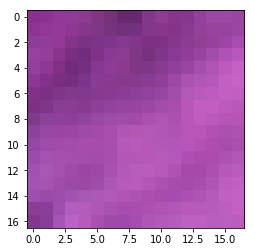

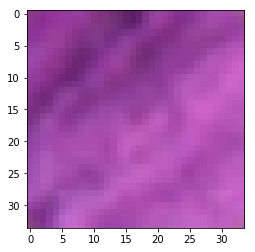

In [11]:
imshow(i1[0])
net.cpu()
result = net(i1.double())
res = result[0].detach().numpy()
net.cuda()
plt.imshow(PS(res, r))

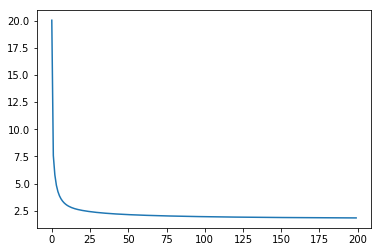

In [12]:
plt.plot(losses)

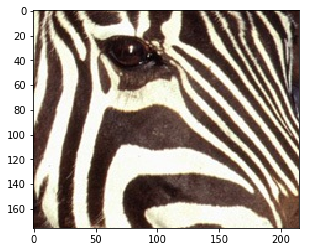

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


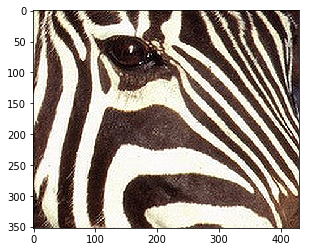

In [14]:
img = plt.imread("datasets/T91/t36.png")

plt.imshow(img)
plt.show()

img = np.transpose(img, (2, 0, 1))
img = torch.Tensor(img).unsqueeze(0).double()
net.cpu()
result = net(img).detach().numpy()
net.cuda()
plt.imshow(PS(result[0], r))
plt.savefig("higher_res.png", dpi=1000)